# Project 1: End-to-End Pipeline to Classify News Articles

In [ ]:
# Notebook Setup
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/ECE 219/Project1-ClassificationDataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Question 1

In [ ]:
print(dataset.shape)

(3476, 8)


**Overview: There are 3476 samples in the dataset, with each having 8 features.**

**Histograms:**

See the histograms below:

a) Looking at the number of alpha-numerical character in each document we what looks like a shifted gaussian. Most documents are cenetered around smaller text counts with a decreasing number of documents having more. The bin for 3000-3500 characters has the highest frequency.

b) We see a relatively even distribution of documents across all 9 topics in the dataset.

c) Between the overarching sports and climate labels we similarly see a relatively even split. The data seems to be properly sampled, with no immediately obvious bias.

In [ ]:
#a
import re
count = [len(re.findall(r'\w',full_text)) for full_text in dataset['full_text']]

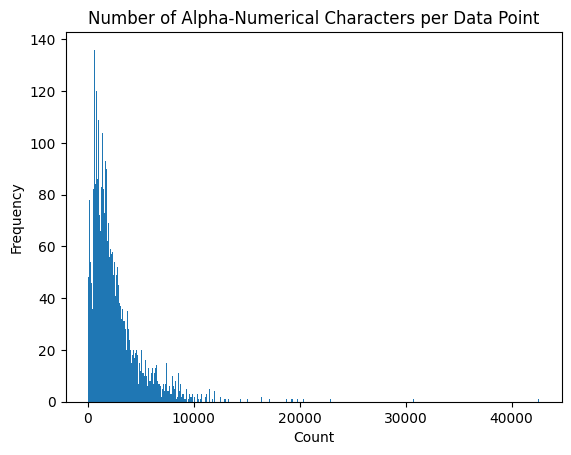

In [ ]:
hist,_ ,_ = plt.hist(count, bins = 500)
plt.title("Number of Alpha-Numerical Characters per Data Point")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
max_freq = max(hist)
i = np.where(hist == max_freq)[0]
print("Max frequency of "+str(max_freq)+" occurs in the bin for "+str(i*500)+" to "+str((i+1)*500 -1)+" alphanumeric characters")

Max frequency of 136.0 occurs in the bin for [3000] to [3499] alphanumeric characters


Text(0, 0.5, 'Frequency')

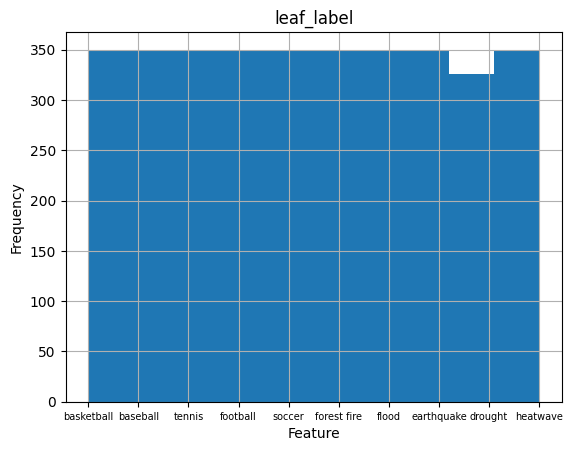

In [ ]:
#b
dataset['leaf_label'].hist(xlabelsize = 7)
plt.title("leaf_label")
plt.xlabel("Feature")
plt.ylabel("Frequency")

Text(0.5, 0, 'Feature')

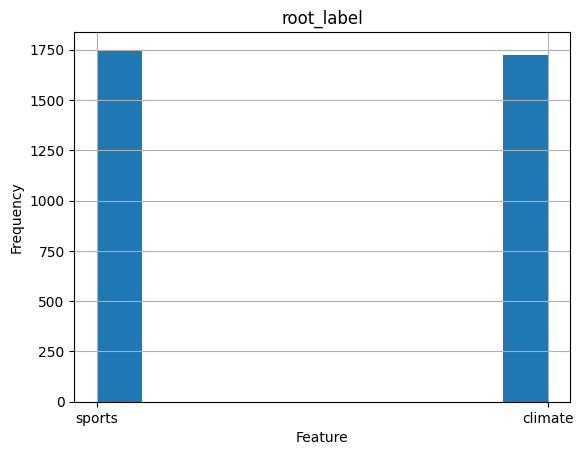

In [ ]:
#c
dataset['root_label'].hist()
plt.title("root_label")
plt.ylabel("Frequency")
plt.xlabel("Feature")

Interpretation:
Each of the 3476 samples belongs to either the sports feature or the climate feature. Beyond these root classes, they then fall into leaf labels. Withthis dataset, there is about an equal number of datapoints for each of the labels with only earthquake being slightly underrepresented.

## Question 2

In [ ]:
import random
np.random.seed(42)
random.seed(42)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset[["full_text","root_label"]], test_size=0.2)

In [ ]:
print(train.shape, test.shape)

(2780, 2) (696, 2)


**There are 2780 training samples and 696 testing samples.**

## Question 3
NOTE: NUMBERS STILL NEED TO BE REMOVED

In [ ]:
# Cleaning each data sample to remove HTML artefacts
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [ ]:
#BAG OF WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer as wnl

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
#The tags from pos tag do not line up with wordnet so need to convert them from universal to wordnet
def wordnet_pos_tag(tag):
  if tag.startswith('J'):
      return 'a'
  elif tag.startswith('V'):
      return 'v'
  elif tag.startswith('N'):
      return 'n'
  elif tag.startswith('R'):
      return 'r'
  else:
      return 'n'

In [ ]:
#create a function to clean, tokenize, and lemmatize with tagging the texts before we put them into the vectorizer

def lemmatize_with_pos_tag(text):

  text = clean(text)

  #tokenize and tag
  tagged_text_temp = pos_tag(word_tokenize(text, language = 'english'), tagset = "universal")

  #convert tags
  tagged_text = [(word.lower(), wordnet_pos_tag(tag)) for word, tag in tagged_text_temp]
  # print(tagged_text)

  #now lemmatize while ignoring numbers
  lemmatizer = wnl()
  lemmatized_tokens = [lemmatizer.lemmatize(word, pos) for word, pos in tagged_text if not any(char.isdigit() for char in word)]

  output = ' '.join(lemmatized_tokens)



  #now rejoin to enable use in vectorizer
  return output



In [ ]:
#Lets create an extra data column in case anything goes wrong and apply the function
train['lemmatized_text'] = train['full_text'].apply(lemmatize_with_pos_tag)
test['lemmatized_text'] = test['full_text'].apply(lemmatize_with_pos_tag)

In [ ]:
print(train['lemmatized_text'][100])

'san francisco ( ap ) andre iguodala , a four-time champion with the golden state warrior during a nba career , be retire . it just the right time , the iguodala tell andscape on friday in a telephone interview . time start to get limited for me and i didnt want to put anything in the back seat . i didnt want to have to try to delegate time anymore . especially with on the court , off the court with family . a lot . '' he say family have a lot of do with his decision . you want to play at a high level . but then family be a lot . my son be and then two girl . so , ( im ) look forward to see them grow up in those important year , '' he say . iguodala , the no . overall pick in the nba draft out of arizona , play in game . he spend eight season with the philadelphia , one in denver , six with golden state , two in miami and the last two back with the warrior . he be part of nba champion in , , and and the mvp of the final in . over his career , he average point include a high of with the

In [ ]:
#Now use the vectorizer
vect = CountVectorizer(min_df=3, stop_words='english')

#via helper code
#train
X_train_counts = vect.fit_transform(train['lemmatized_text'])
X_train_counts.shape # 1162 docs, 19610 terms in the training dataset
#stats
print(vect.get_feature_names_out()[:100])
print('-' * 20)
print(vect.vocabulary_.get('circuitry'))
print(vect.get_feature_names_out()[1313])
#test
X_test_counts = vect.transform(test['lemmatized_text'])
X_test_counts.shape

['___' 'aa' 'aaa' 'aac' 'aaron' 'ab' 'abandon' 'abate' 'abbreviate'
 'abbreviated' 'abby' 'abc' 'abcnews' 'abdominal' 'abduct' 'abdul'
 'abdullah' 'abed' 'abepura' 'ability' 'ablaze' 'able' 'abnormal'
 'abnormally' 'aboard' 'aboriginal' 'abraham' 'abreu' 'abroad' 'abrupt'
 'absence' 'absent' 'absolute' 'absolutely' 'absorb' 'abstract' 'absurd'
 'abu' 'abundance' 'abundant' 'abuse' 'abuser' 'abut' 'ac' 'academic'
 'academy' 'acapulco' 'acc' 'accelerate' 'accelerated' 'acceleration'
 'accelerator' 'accent' 'accept' 'acceptance' 'access' 'accessibility'
 'accessible' 'accessory' 'accesswire' 'accident' 'accidental'
 'accidentally' 'acclaim' 'acclaimed' 'acclimatise' 'accolade'
 'accommodate' 'accommodation' 'accompany' 'accomplish' 'accomplished'
 'accomplishment' 'accord' 'accordance' 'according' 'accordingly'
 'account' 'accountability' 'accountable' 'accounting' 'accumulate'
 'accumulated' 'accumulation' 'accuracy' 'accurate' 'accurately'
 'accusation' 'accuse' 'accuweather' 'ace' 'ace

(696, 13327)

In [ ]:
#using tfidf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print('-' * 20)
print(X_train_counts.toarray()[:30,:5])
print('-' * 20)
print(X_train_tfidf.toarray()[:30,:5])

(2780, 13327)
(696, 13327)
--------------------
[[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
--------------------
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.01717244]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.   

**What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?**

The most obvious difference between the two is that lemmatization is more resource intensive and takes longer; this is a result of the need to look to a database to properly lemmatize. Stemming is faster and more rule-based, essentially more computatinally efficient. Since it just trims with less reservation than lemmatizing it can result in a smaller dictionary size.

**min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?**

By setting a higher minimum document frequency, we are setting a higher threshold for the number of occurences a word needs across documents in order for it be included in the matrix. A higher min df will lead to less words included and less columns in the TF-IDF matrix.

**Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing?**

In terms of stopwords it makes more sense to remove them prior to lemmatization in order to increase the efficiency of lemmatization.

For punctuation it could be better to remove them prior to lemmatization to aid that process, unless we perhaps specifically care to analyze the sentence structure, which we don't here.

Numbers are removed beforehand for the same reason as stopwords, so that lemmatization does not need to waste time on them.

**Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2.**

train: (2780, 13327)
test: (696, 13327)

## Question 4


Text(0, 0.5, 'Explained Variance Ratio')

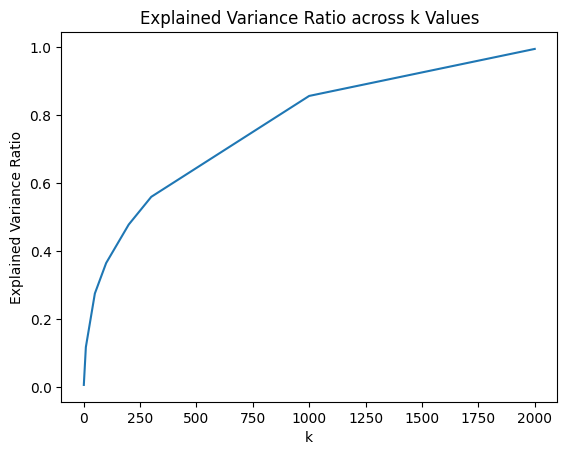

In [ ]:
# Latent Semantic Indexing (LSI)
from sklearn.decomposition import TruncatedSVD

# Plotting the explained variance ratio across different k values
k = [1, 10, 50, 100, 200, 300, 1000, 2000]

def LSI_ratio_compute(k):
  svd = TruncatedSVD(n_components = k, n_iter = 7)
  X_train_LSI = svd.fit_transform(X_train_tfidf)
  X_test_LSI = svd.transform(X_test_tfidf)
  return svd.explained_variance_ratio_.sum()

variances = []
for i in k:
  variances.append(LSI_ratio_compute(i))

plt.plot(k,variances)
plt.title("Explained Variance Ratio across k Values")
plt.xlabel('k')
plt.ylabel("Explained Variance Ratio")

The explained variance ratio plot looks like a logarithmic plot with it approaching a variance ratio of 1 as the k increases into the thousands. The plots concavity suggests that there is a large difference between k values lower than 1000 but beyond that there is a negligible difference.

In [ ]:
# As per the project documentation, k = 50
k = 50

# Latent Semantic Indexing (LSI)
svd = TruncatedSVD(n_components = k, n_iter = 7) #Choose random state for consistent results
X_train_LSI = svd.fit_transform(X_train_tfidf)
X_test_LSI = svd.transform(X_test_tfidf)


# Non-negative Matrix Factorization (NMF)
from sklearn.decomposition import NMF

nmf = NMF(n_components = k, init = 'random', max_iter = 1000)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

# Froebenius Norm Errors
from sklearn.utils.extmath import randomized_svd

u,sigma,vt = randomized_svd(X_train_tfidf,n_components = k)
x_k = np.dot(np.dot(u,np.diag(sigma)), vt)
lsi_f = np.sqrt(np.sum(np.square(x_k - X_train_tfidf)))

u_test,sigma_test,vt_test = randomized_svd(X_test_tfidf, n_components = k)
x_k_test = np.dot(np.dot(u_test, np.diag(sigma_test)), vt_test)
lsi_f_test = np.sqrt(np.sum(np.square(x_k_test - X_test_tfidf)))

print("Froebenius Norm for LSI train: " + str(lsi_f))
print("Froebenius Norm for LSI test: " + str(lsi_f_test))

WH = np.dot(X_train_NMF, nmf.components_)
nmf_f = np.sqrt(np.sum(np.square(WH - X_train_tfidf)))

WH_test = np.dot(X_test_NMF, nmf.components_)
nmf_f_test = np.sqrt(np.sum(np.square(WH_test - X_test_tfidf)))

print("\nFroebenius Norm for NMF train: " + str(nmf_f))
print("Froebenius Norm for NMF test: " + str(nmf_f_test))

Froebenius Norm for LSI train: 44.16577496140805
Froebenius Norm for LSI test: 21.57762905190812

Froebenius Norm for NMF train: 44.48454784232797
Froebenius Norm for NMF test: 22.739048236067404


The larger error is the Froebenius MSE for NMF with a slightly higher value for the testing data. This is because in NMF there is a requirement that the values must be non-negative whereas LSI does not have this limitation. This means LSI better preserves the features of the original dataset and thus will perform better.

## Question 5

In [ ]:
import itertools
# Helper function to plot the confusion matrix
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          classes = ['sports', 'climate']
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn import svm

# Helper function to calculate the false positive rate and the true positive rate
def calculate_fpr_tpr(prob_func, labels):
  fpr, tpr, t = metrics.roc_curve(labels, prob_func, pos_label = 1)
  return fpr, tpr

# Helper function to train and plot a SVM
def calculate_svc(train_set, test_set, binary_train_target, binary_test_target, gamma, C = 1):
  svc = svm.SVC(C = C, probability = True, kernel = 'linear')
  svc.fit(train_set, binary_train_target)
  svc_predicted = svc.predict(test_set)

  print("Gamma: " + str(gamma))
  print("Accuracy: " + str(metrics.accuracy_score(binary_test_target.ravel(), svc_predicted)))
  print("Precision: " + str(metrics.precision_score(binary_test_target.ravel(), svc_predicted)))
  print("Recall: " + str(metrics.recall_score(binary_test_target.ravel(), svc_predicted)))
  print("F-1 Score: " + str(metrics.f1_score(binary_test_target.ravel(), svc_predicted)))

  cnf_matrix = metrics.confusion_matrix(binary_test_target, svc_predicted)
  np.set_printoptions(precision = 2)
  plt.figure()
  plot_confusion_matrix(cnf_matrix, title = "Confusion Matrix")
  fpr,tpr = calculate_fpr_tpr(svc.decision_function(test_set), binary_test_target)
  return fpr,tpr

In [ ]:
# Changing root labels to be binary numbers for easier SVM training
y_train_encoded = train["root_label"].copy()
y_test_encoded = test["root_label"].copy()

y_train_encoded[y_train_encoded == 'sports'] = 0
y_test_encoded[y_test_encoded == 'sports'] = 0
y_train_encoded[y_train_encoded== 'climate'] = 1
y_test_encoded[y_test_encoded == 'climate'] = 1

y_test_e = y_test_encoded.astype(str).astype(int)
y_train_e = y_train_encoded.astype(str).astype(int)

Hard SVM using LSI
Gamma: auto
Accuracy: 0.9698275862068966
Precision: 0.9582089552238806
Recall: 0.9786585365853658
F-1 Score: 0.9683257918552036
Confusion matrix, without normalization
[[354  14]
 [  7 321]]


<Figure size 640x480 with 0 Axes>

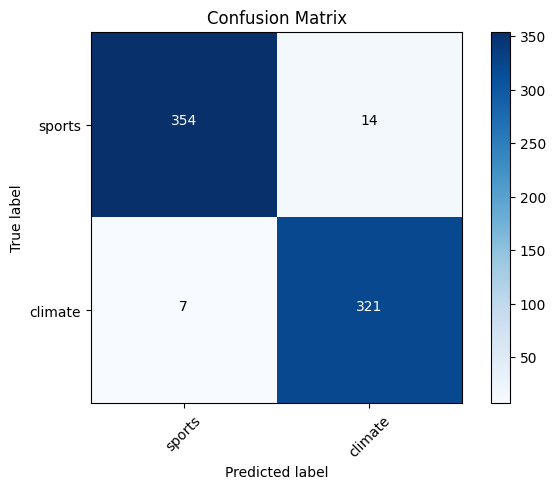


Soft SVM using LSI
Gamma: auto
Accuracy: 0.47126436781609193
Precision: 0.47126436781609193
Recall: 1.0
F-1 Score: 0.640625
Confusion matrix, without normalization
[[  0 368]
 [  0 328]]


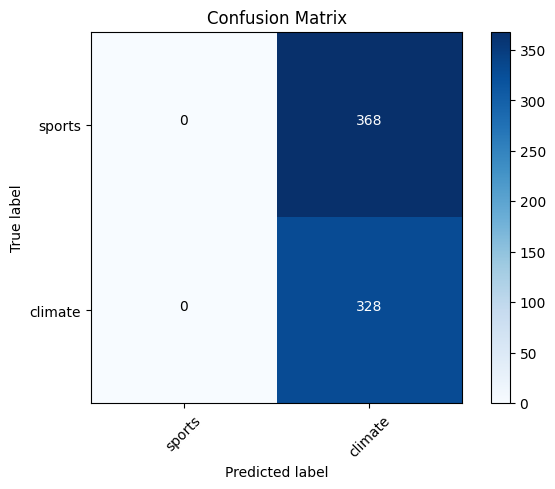

In [ ]:
# Training two linear SVMs
plt.gcf().clear()

# First SVM (hard margin)
gamma_h = 'auto'
C = 1000
fprs_h = []
tprs_h = []

# Moving forward with LSI because of its better performance
print("Hard SVM using LSI")
fpr_h, tpr_h = calculate_svc(X_train_LSI, X_test_LSI, y_train_e, y_test_e, gamma_h,C=C)

fprs_h.append(fpr_h)
tprs_h.append(tpr_h)

print()

# Second SVM (soft margin)
gamma_s = 'auto'
C = 0.0001
fprs_s = []
tprs_s = []

print("Soft SVM using LSI")
fpr_s, tpr_s = calculate_svc(X_train_LSI, X_test_LSI, y_train_e, y_test_e, gamma_s,C=C)

fprs_s.append(fpr_s)
tprs_s.append(tpr_s)

Area under hard SVM ROC curve: 0.9969843584305409
Area under soft SVM ROC curve: 0.9868272799575821


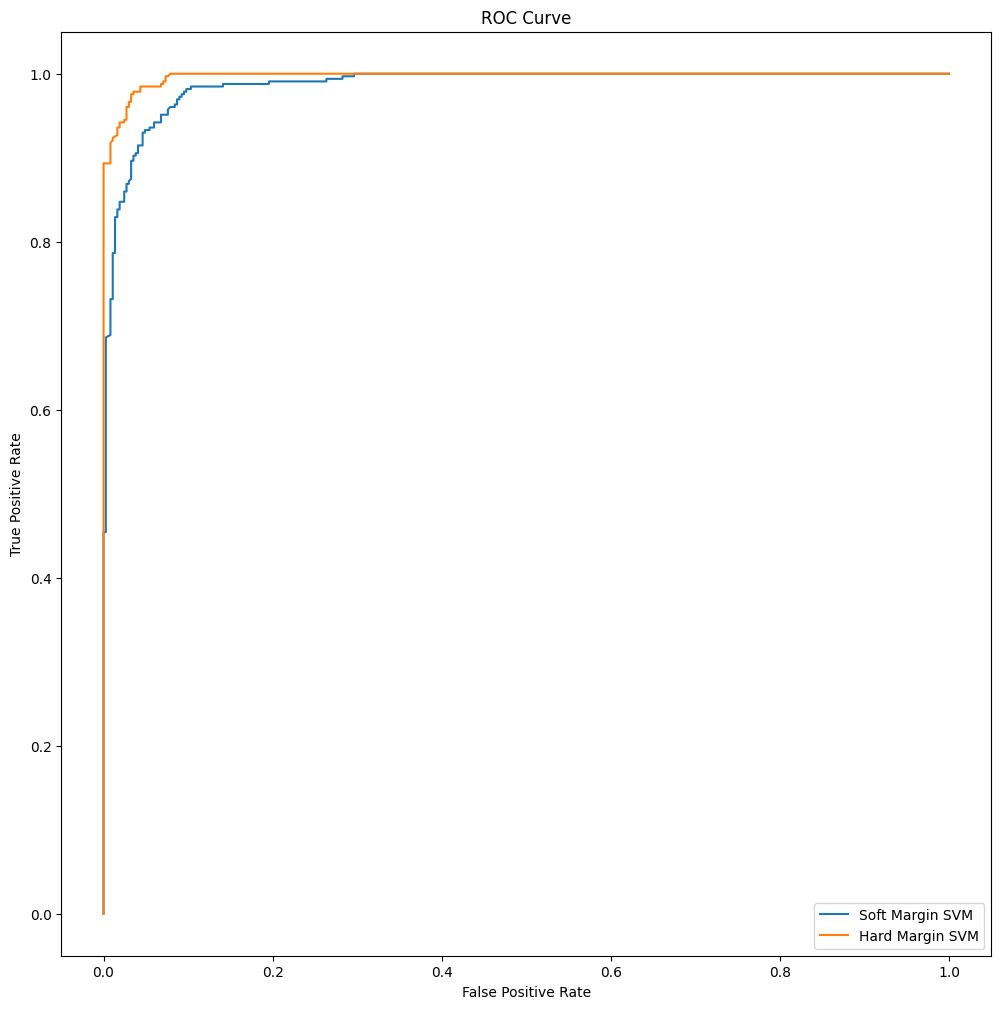

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(12,12))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")

plt.plot(fpr_s, tpr_s, label = "Soft Margin SVM")
plt.plot(fpr_h, tpr_h, label = "Hard Margin SVM")
plt.legend()

roc_a_h = metrics.auc(fpr_h,tpr_h)
roc_a_s = metrics.auc(fpr_s,tpr_s)

print("Area under hard SVM ROC curve: " + str(roc_a_h))
print("Area under soft SVM ROC curve: " + str(roc_a_s))

There is a larger area underneath the hard SVM because it performed better and had a higher true positive rate than the soft margin SVM. This is because of the sensitivity to the penalty term. In the confusion matrix, you can see that the soft margin SVM has more mislabeled datapoints because of the flexibility with the penalty term.

SVM using LSI
Gamma: auto
Accuracy: 0.9698275862068966
Precision: 0.9582089552238806
Recall: 0.9786585365853658
F-1 Score: 0.9683257918552036
Confusion matrix, without normalization
[[354  14]
 [  7 321]]


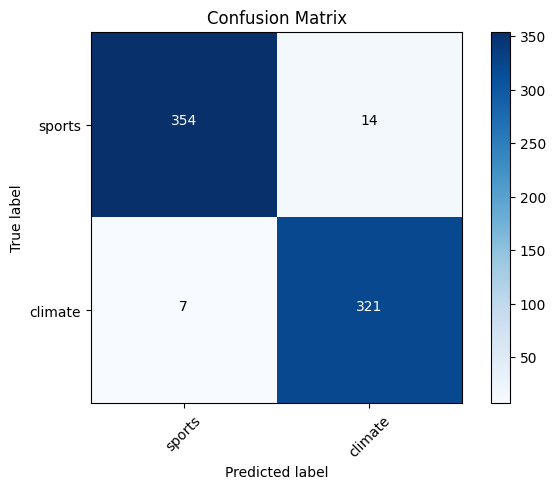

In [ ]:
# When gamma is 100000
gamma = 'auto'
C = 100000
print("SVM using LSI")
fpr_s, tpr_s = calculate_svc(X_train_LSI, X_test_LSI, y_train_e, y_test_e, gamma_s,C=C)


You can observe that the very high penalty term is actually overfitting the data and leading to more misclassifications than when the penalty term was 1000.

In [ ]:
# Cross-validation to choose optimal penalty term
from sklearn.model_selection import GridSearchCV

k_folds = 5

# Choosing penalty terms to test
parameters = {'C':[0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]}
svm_cv = svm.SVC(probability = True)
svm_cv_grid = GridSearchCV(svm_cv, parameters, cv = k_folds)
svm_cv_grid.fit(X_train_LSI, y_train_e)

pd.DataFrame(svm_cv_grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.333184,0.404513,0.135482,0.039695,0.001,{'C': 0.001},0.503597,0.503597,0.503597,0.501799,0.501799,0.502878,0.000881,10
1,1.696533,0.029078,0.097653,0.002751,0.01,{'C': 0.01},0.875899,0.861511,0.874101,0.865108,0.910072,0.877338,0.017229,9
2,1.071249,0.235799,0.058151,0.018365,0.1,{'C': 0.1},0.940647,0.951439,0.944245,0.937050,0.956835,0.946043,0.007194,8
3,0.372164,0.011757,0.020070,0.000919,1,{'C': 1},0.958633,0.956835,0.960432,0.949640,0.956835,0.956475,0.003668,3
4,0.330150,0.017193,0.015453,0.000518,10,{'C': 10},0.958633,0.971223,0.962230,0.960432,0.956835,0.961871,0.005010,1
5,0.366337,0.015298,0.013912,0.000531,100,{'C': 100},0.953237,0.971223,0.960432,0.960432,0.958633,0.960791,0.005845,2
6,0.466368,0.024681,0.014336,0.000637,1000,{'C': 1000},0.953237,0.958633,0.953237,0.953237,0.949640,0.953597,0.002878,4
7,0.754738,0.039770,0.023889,0.003284,10000,{'C': 10000},0.956835,0.956835,0.946043,0.955036,0.951439,0.953237,0.004101,5
8,0.463080,0.015952,0.014695,0.001055,100000,{'C': 100000},0.956835,0.956835,0.946043,0.955036,0.951439,0.953237,0.004101,5
9,0.475557,0.029614,0.014169,0.000419,1000000,{'C': 1000000},0.956835,0.956835,0.946043,0.955036,0.951439,0.953237,0.004101,5


In [ ]:
pd.DataFrame(svm_cv_grid.cv_results_)[['param_C','mean_test_score','rank_test_score']]

,param_C,mean_test_score,rank_test_score
0,0.001,0.502878,10
1,0.01,0.877338,9
2,0.1,0.946043,8
3,1,0.956475,3
4,10,0.961871,1
5,100,0.960791,2
6,1000,0.953597,4
7,10000,0.953237,5
8,100000,0.953237,5
9,1000000,0.953237,5


The best penalty term is when it is 10.

SVM using LSI with Optimal Penalty
Gamma: auto
Accuracy: 0.9583333333333334
Precision: 0.9628482972136223
Recall: 0.948170731707317
F-1 Score: 0.955453149001536
Confusion matrix, without normalization
[[356  12]
 [ 17 311]]


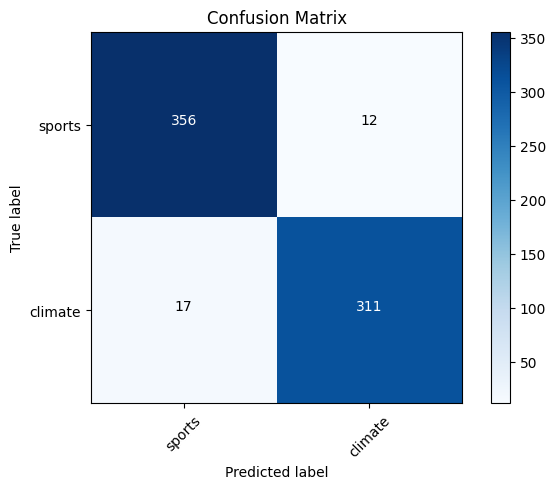

In [ ]:
# Performance with optimized penalty term
C = 10

print("SVM using LSI with Optimal Penalty")
fpr_opt,tpr_opt = calculate_svc(X_train_LSI, X_test_LSI, y_train_e, y_test_e, gamma_s,C=C)


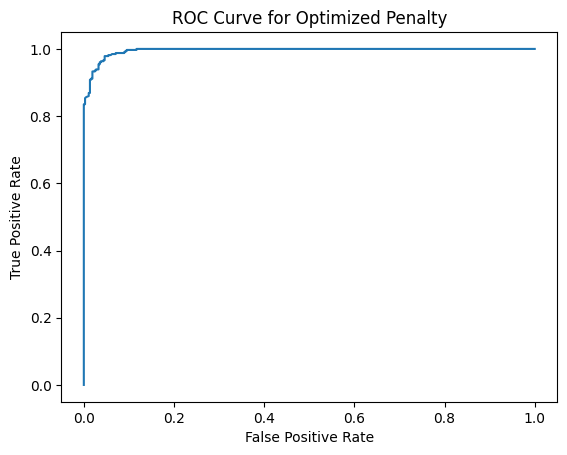

In [ ]:
plt.figure()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optimized Penalty")
plt.plot(fpr_opt, tpr_opt)

## Question 6

In [ ]:
# Helper function for logistic regression
def calculate_logistic(train_set, test_set, binary_train_target, binary_test_target, C, solver, penalty):
    log = LogisticRegression(penalty=penalty, solver=solver,max_iter=10000, C = C)
    log.fit(train_set, binary_train_target)
    pred = log.predict(test_set)

    print('C value: ' + str(C))
    print('Penalty: ' + str(penalty))
    print('Accuracy: ' + str(metrics.accuracy_score(binary_test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(binary_test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(binary_test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(binary_test_target.ravel(), pred)))
    print("Coefficient Statistics: ")
    print("mean = %f, std = %f" % (np.mean(log.coef_), np.std(log.coef_)))

    cnf_matrix = metrics.confusion_matrix(binary_test_target, pred)
    np.set_printoptions(precision=2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix,title='Confusion Matrix')

    # calculate fpr_tpr
    fpr, tpr = calculate_fpr_tpr(log.decision_function(test_set), binary_test_target)
    return fpr, tpr

In [ ]:
# Finding optimal logistic regression regularization coefficient
from sklearn.linear_model import LogisticRegression

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Regularization strength
parameters = {'C':[0.0001, 0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
k_folds = 5

# Without regularization
logistic_0 = LogisticRegression(penalty="none", max_iter = 10000)
logistic_0_grid = GridSearchCV(logistic_0, parameters)
logistic_0_grid.fit(X_train_LSI, y_train_e)
print("Logistic Regression without Regularization:")
print(pd.DataFrame(logistic_0_grid.cv_results_)[['param_C','mean_test_score']])
print()

# With L1 regularization
logistic_L1 = LogisticRegression(solver='saga',penalty="l1",max_iter=10000)
logistic_L1_grid = GridSearchCV(logistic_L1, parameters, cv = k_folds)
logistic_L1_grid.fit(X_train_LSI, y_train_e)
print("Logistic Regression with L1 Regularization")
print(pd.DataFrame(logistic_L1_grid.cv_results_)[['param_C','mean_test_score']])
print()

# With L2 regularization
logistic_L2 = LogisticRegression(solver='saga',penalty='l2',max_iter = 10000)
logistic_L2_grid = GridSearchCV(logistic_L2, parameters, cv = k_folds)
logistic_L2_grid.fit(X_train_LSI, y_train_e)
print("Logistic Regression with L2 Regularization")
print(pd.DataFrame(logistic_L2_grid.cv_results_)[['param_C','mean_test_score']])

Logistic Regression without Regularization:
  param_C  mean_test_score
0  0.0001         0.957914
1   0.001         0.957914
2   0.001         0.957914
3    0.01         0.957914
4     0.1         0.957914
5       1         0.957914
6      10         0.957914
7     100         0.957914
8    1000         0.957914
9   10000         0.957914

Logistic Regression with L1 Regularization
  param_C  mean_test_score
0  0.0001         0.497842
1   0.001         0.498561
2   0.001         0.499281
3    0.01         0.500000
4     0.1         0.924820
5       1         0.949640
6      10         0.958273
7     100         0.957194
8    1000         0.957194
9   10000         0.957554

Logistic Regression with L2 Regularization
  param_C  mean_test_score
0  0.0001         0.502878
1   0.001         0.816547
2   0.001         0.816906
3    0.01         0.939209
4     0.1         0.942086
5       1         0.949281
6      10         0.957554
7     100         0.958993
8    1000         0.957914
9   

Logistic Regression with no regularization
C value: 1
Penalty: none
Accuracy: 0.9640804597701149
Precision: 0.954954954954955
Recall: 0.9695121951219512
F-1 Score: 0.962178517397882
Coefficient Statistics: 
mean = -0.452223, std = 17.639028
Confusion matrix, without normalization
[[353  15]
 [ 10 318]]


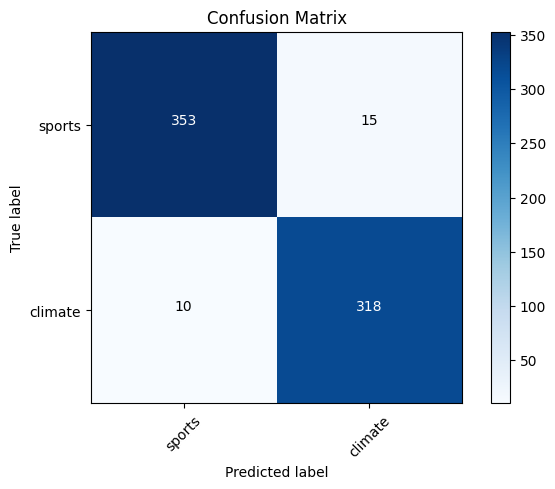

In [ ]:
# Training logistic classifier without regularization

print("Logistic Regression with no regularization")
fpr_0,tpr_0 = calculate_logistic(X_train_LSI, X_test_LSI, y_train_e, y_test_e, C=1,solver='lbfgs',penalty="none")

Logistic Regression with L1 Regularization
C value: 10
Penalty: l1
Accuracy: 0.9640804597701149
Precision: 0.954954954954955
Recall: 0.9695121951219512
F-1 Score: 0.962178517397882
Coefficient Statistics: 
mean = -0.526603, std = 12.422942
Confusion matrix, without normalization
[[353  15]
 [ 10 318]]


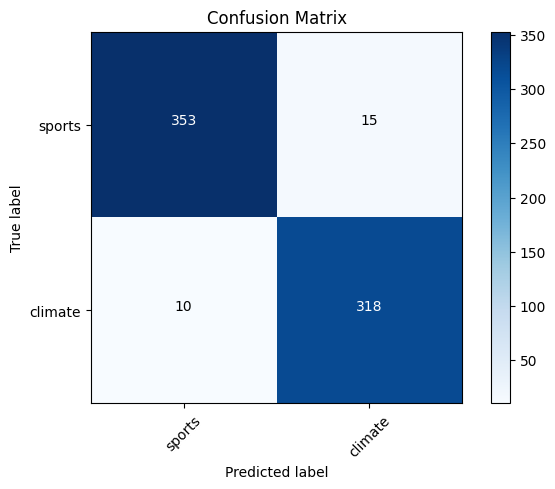

In [ ]:
# Training logistic classifier with L1 regularization
print("Logistic Regression with L1 Regularization")
fpr_L1,tpr_L1 = calculate_logistic(X_train_LSI, X_test_LSI, y_train_e, y_test_e, C=10,solver='liblinear',penalty="l1")

Logistic Regression with L2 Regularization
C value: 100
Penalty: l2
Accuracy: 0.9655172413793104
Precision: 0.9578313253012049
Recall: 0.9695121951219512
F-1 Score: 0.9636363636363636
Coefficient Statistics: 
mean = -0.205969, std = 10.694505
Confusion matrix, without normalization
[[354  14]
 [ 10 318]]


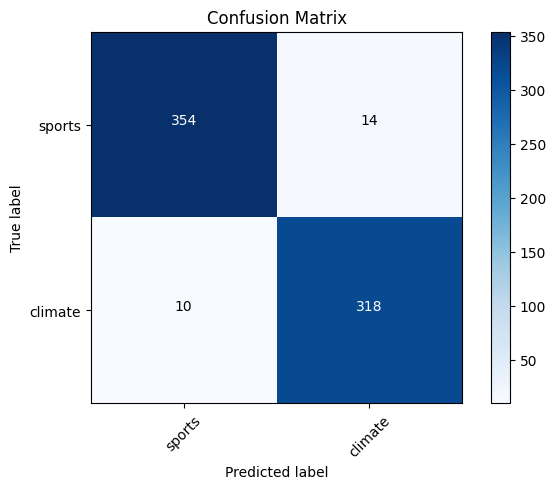

In [ ]:
# Training logistic classifier with L2 regularization
print("Logistic Regression with L2 Regularization")
fpr_L2,tpr_L2 = calculate_logistic(X_train_LSI, X_test_LSI, y_train_e, y_test_e, C=100,solver='liblinear',penalty="l2")

The optimal regularization strengths for each are as follows: C = 1 for no regularization, C = 10 for L1 regularization, and C = 100 for L2 regularization. The selection of C = 1 is arbitrary because there is an equal error for each of the regularization strengths due to there not being regularization in the first place.

Area for no regularization: 0.9965701219512195
Area for L1 regularization: 0.9958576352067869
Area for L2 regularization: 0.9959653366914104


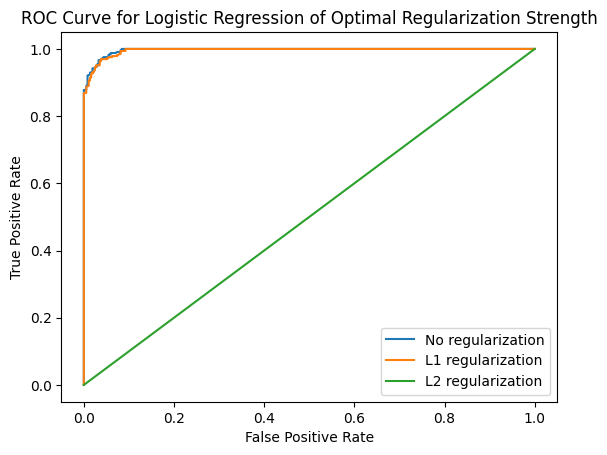

In [ ]:
# Plotting the ROC curve
plt.figure()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression of Optimal Regularization Strength")

plt.plot(fpr_0,tpr_0, label = "No regularization")
plt.plot(fpr_L1,tpr_L1, label = "L1 regularization")
plt.plot(tpr_L2,tpr_L2, label = "L2 regularization")
plt.legend()

# Area under curve to evaluate performance
roc_0 = metrics.auc(fpr_0,tpr_0)
roc_L1 = metrics.auc(fpr_L1,tpr_L1)
roc_L2 = metrics.auc(fpr_L2,tpr_L2)
print("Area for no regularization: " + str(roc_0))
print("Area for L1 regularization: " + str(roc_L1))
print("Area for L2 regularization: " + str(roc_L2))

The model that performed the best was the model for no regularization as based by the area underneath the ROC curve. The regularization parameter can affect the test error by overfitting the data if it is too strong or by underfitting the data by being too weak. By having each of the datapoints unregularized, they were treated equally likely contributing to the high performance of the no regularization logistic curve. We might be interested in L1 regularization for feature selection to drive features to 0. L2 regularization shrinks features so it is good to weigh some features while keeping them all in the equation. No regularization can be used to build more complex models.

Logistic regression is a decision boundary based on probability using all available data points. SVM uses only data points close to the decision boundary it forms. In this way, SVM ignores and thus is robus to outliers and logistic regression is more apt to overfit.

## Question 7

In [ ]:
#building a Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

def NB_pred(train, test, train_target, test_target):
    #fit and predict
    gnb = GaussianNB()
    gnb.fit(train, train_target)
    pred = gnb.predict(test)

    print('Accuracy: ' + str(metrics.accuracy_score(test_target.ravel(), pred)))
    print('Precision: ' + str(metrics.precision_score(test_target.ravel(), pred)))
    print('Recall: ' + str(metrics.recall_score(test_target.ravel(), pred)))
    print('F-1 Score: ' + str(metrics.f1_score(test_target.ravel(), pred)))

    #confusion matrix
    confusion = metrics.confusion_matrix(test_target, pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(confusion, title='Confusion matrix w/o normalization')
    plt.show()

    #metrics
    fpr, tpr = calculate_fpr_tpr(gnb.predict_proba(test)[:,1], test_target)
    return fpr, tpr

Naive Bayes w/ LSI
Accuracy: 0.9137931034482759
Precision: 0.958904109589041
Recall: 0.8536585365853658
F-1 Score: 0.9032258064516128
Confusion matrix, without normalization
[[356  12]
 [ 48 280]]


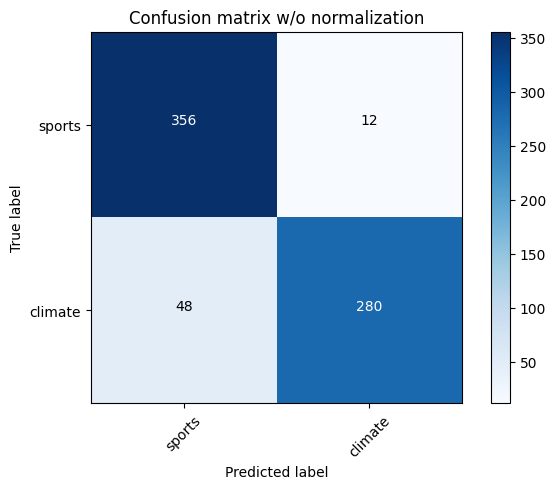

In [ ]:
fprs_NB = []
tprs_NB = []


print('Naive Bayes w/ LSI')

fpr_NB,tpr_NB = NB_pred(X_train_LSI, X_test_LSI, y_train_encoded.astype(str).astype(int), y_test_encoded.astype(str).astype(int))
fprs_NB.append(fpr_NB)
tprs_NB.append(tpr_NB)

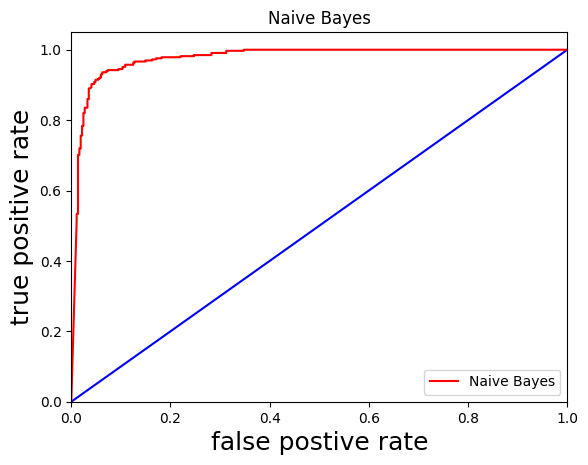

In [ ]:
plt.figure()
plt.plot([0, 1], [0, 1], color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=23)

plt.plot(fpr_NB, tpr_NB, 'red', label='Naive Bayes')

plt.legend()
plt.title('Naive Bayes')
plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.show()

## Question 8

In [ ]:
# Define the different types of feature extraction
# df = 3,5 and comparing lemma and stemmed

from nltk.stem import PorterStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer

analyzer = CountVectorizer().build_analyzer()
stemmer = PorterStemmer()

word_net = nltk.wordnet.WordNetLemmatizer()

def penn2net(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    net_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return net_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    return [word_net.lemmatize(word.lower(), pos=penn2net(tag))
            for word, tag in nltk.pos_tag(list_word)]


# Define helper functions for the pipeline
def stemmed(doc):
  return (stemmer.stem(word) for word in analyzer(doc) if not word.isdigit())
def lemma(doc):
  return (word for word in lemmatize_sent(analyzer(doc)) if not word.isdigit())

vectorizer_df3_lemma = CountVectorizer(min_df = 3, analyzer = lemma, stop_words = 'english')
vectorizer_df5_lemma = CountVectorizer(min_df = 5, analyzer = lemma, stop_words = 'english')
vectorizer_df3_stemmed = CountVectorizer(min_df = 3, analyzer = stemmed, stop_words = 'english')
vectorizer_df5_stemmed = CountVectorizer(min_df = 5, analyzer = stemmed, stop_words = 'english')


In [ ]:
# Construct a Pipeline to perform feature extraction, dimensionality reduction, and classification
# Should include loading data, feature extraction, dimensionality reduction, clsasifier

from sklearn.pipeline import Pipeline

# To save large results, cache in temporary files
from tempfile import mkdtemp
from shutil import rmtree
import joblib

loc = mkdtemp()
mem = joblib.Memory(location = loc, verbose = 10)

k = 5

pipeline = Pipeline([
    ('vect', vectorizer_df3_lemma),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components = 50)),
    ('classifier', LinearSVC())
], memory = mem)

# Create a parameter grid of all posibilities
param_grid = [
    {
        'vect': [vectorizer_df3_stemmed, vectorizer_df5_stemmed,
                 vectorizer_df3_lemma, vectorizer_df5_lemma],
        'reduce_dim': [TruncatedSVD(n_components = 5),
                       TruncatedSVD(n_components = 30),
                       TruncatedSVD(n_components = 80),
                       NMF(n_components=5, init = 'random', max_iter=10000),
                       NMF(n_components=30, init = 'random', max_iter=10000),
                       NMF(n_components=80, init = 'random', max_iter=10000)],
        'classifier': [LinearSVC(C = 1, max_iter = 10000),
                       LogisticRegression(penalty = "l1", C = 10, max_iter = 10000, solver = 'liblinear'),
                       LogisticRegression(penalty = "l2", C = 100, max_iter = 10000, solver = 'liblinear'),
                       GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv = k, n_jobs = 1, param_grid = param_grid, scoring = 'accuracy')
grid.fit(train['full_text'], y_train_e)
rmtree(loc)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stemmed at 0x7d5831530820>, min_df=3,
                stop_words='english'), 
560     'In its second year back since the pandemic, t...
707     'Lars Ulrich (L) and Kirk Hammett of Metallica...
424     'Apr 16, 2023; Houston, Texas, USA; General vi...
1093    'Guard Isaac Seumalo is the winner of the 2023...
647     'Since 1952, I have been affiliated as a playe...
                              ...                        
1095    '(Photo by Justin Casterline/Getty Images)\n\n...
1130    'COOKEVILLE, Tenn. (WKRN) — The Golden Eagles ...
1294    'FanDuel Sportsbook has launched an exclusive ...
860     'Hunting stories are a Maine tradition, just l...
3174    'By Lewis Jackson\n\nSYDNEY (Reuters) -Thousan...
Name: full_text, Length: 2224, dtype: object, 
560     0
707     0
424     0
1093    0
647   

KeyboardInterrupt: 

In [ ]:
pipeline_results = pd.DataFrame(grid.cv_results_)
pipeline_results = pipeline_results.sort_values(by = "mean_test_score", ascending = False)
pipeline_results.params[95]

The five best combinations are as follows:

1.   Logistic Regression with L2 regularization, LSI dimensionality reduction with k = 80, and stemming as a compression module with min.df = 5. The mean test score is 0.521223.
2.   LinearSVC classifier, LSI dimensionality reduction with k = 80, and stemming as a compression module with a min.df = 5. The mean test score is 0.521223.
3.  Logistic Regression with L1 regularization, LSI dimensionality reduction with k = 80, and stemming as a compression module with min.df = 5. The mean test score is 0.519784.
4.  Logistic Regression with L2 regularization, NMF dimensionality reduction with k = 80, and stemming as a compression module with min.df = 3. The mean test score is 0.518345.
5.  Gaussian NB classifier, NMF dimensionality reduction with k = 80, and lemmaization as a compression module with min.df = 5. The mean test score is 0.517626.



Overall you can see that across the board having a k=80 is the optimal dimensionality reduction. Other than that, all the regression models made top five with mainly stemming as a compression module. Finding these combinations with this pipeline is specific to this dataset.

## Question 9

In [ ]:
#Question 9
train, test = train_test_split(dataset[["full_text","root_label","leaf_label"]], test_size=0.2)

In [ ]:


#now need to encode the different labels so that they can be predicted
y_train_encoded = train["leaf_label"].copy()
y_test_encoded = test["leaf_label"].copy()
y_train_encoded[y_train_encoded == 'basketball'] = 0
y_test_encoded[y_test_encoded == 'basketball'] = 0
y_train_encoded[y_train_encoded== 'baseball'] = 1
y_test_encoded[y_test_encoded == 'baseball'] = 1
y_train_encoded[y_train_encoded == 'tennis'] = 2
y_test_encoded[y_test_encoded == 'tennis'] = 2
y_train_encoded[y_train_encoded == 'football'] = 3
y_test_encoded[y_test_encoded == 'football'] = 3
y_train_encoded[y_train_encoded == 'soccer'] = 4
y_test_encoded[y_test_encoded == 'soccer'] = 4
y_train_encoded[y_train_encoded == 'forest fire'] = 5
y_test_encoded[y_test_encoded == 'forest fire'] = 5
y_train_encoded[y_train_encoded == 'flood'] = 6
y_test_encoded[y_test_encoded == 'flood'] = 6
y_train_encoded[y_train_encoded == 'earthquake'] = 7
y_test_encoded[y_test_encoded == 'earthquake'] = 7
y_train_encoded[y_train_encoded == 'drought'] = 8
y_test_encoded[y_test_encoded == 'drought'] = 8
y_train_encoded[y_train_encoded == 'heatwave'] = 9
y_test_encoded[y_test_encoded == 'heatwave'] = 9

In [ ]:
train['encoded'] = y_train_encoded.astype(str).astype(int)
test['encoded'] = y_test_encoded.astype(str).astype(int)
#clean and lemmmatize
train['full_text'] = train['full_text'].apply(lemmatize_with_pos_tag)
test['full_text'] = test['full_text'].apply(lemmatize_with_pos_tag)


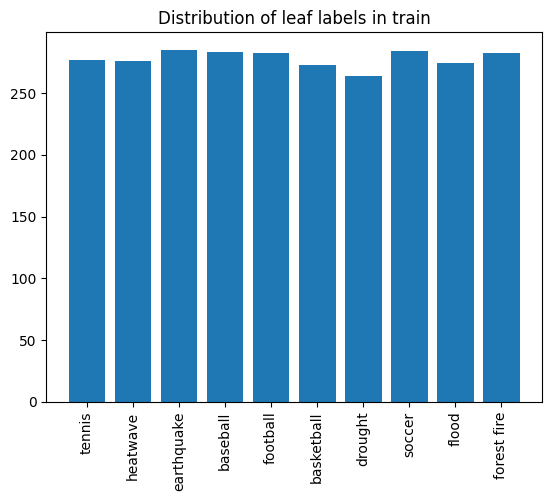

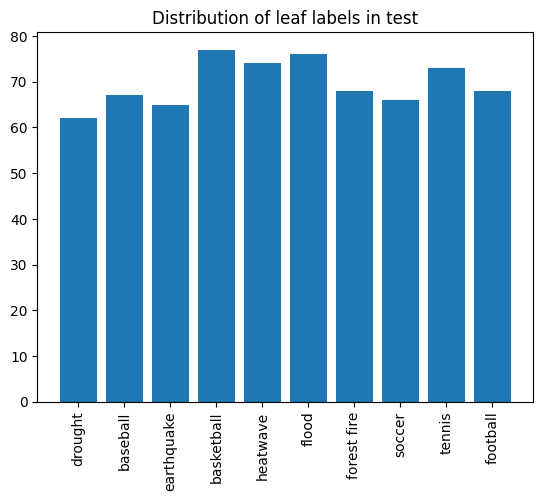

In [ ]:
from collections import Counter, defaultdict
#We want to analyze for imbalances
counter = Counter(train['leaf_label'])
leaf_names = counter.keys()
leaf_counts = counter.values()
# histogram for train
indeces = np.arange(len(leaf_names))
plt.bar(indeces, leaf_counts, .8)
plt.xticks(indeces, leaf_names, rotation = 90)
plt.title("Distribution of leaf labels in train")
plt.show()
counter = Counter(test['leaf_label'])
leaf_names = counter.keys()
leaf_counts = counter.values()
# histogram from train
indeces = np.arange(len(leaf_names))
plt.bar(indeces, leaf_counts, .8)
plt.xticks(indeces, leaf_names, rotation = 90)
plt.title("Distribution of leaf labels in test")
plt.show()

In [ ]:
#Feature extraction
vect = CountVectorizer(min_df=3, stop_words='english')

#via helper code
#train
X_train_counts = vect.fit_transform(train['full_text'])
X_train_counts.shape # 1162 docs, 19610 terms in the training dataset
#test
X_test_counts = vect.transform(test['full_text'])
print(X_test_counts.shape)

#TFIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)


(696, 13559)
(2780, 13559)


In [ ]:
#DIM reduction
svd = TruncatedSVD(n_components = k, n_iter = 7) #Choose random state for consistent results
X_train_LSI = svd.fit_transform(X_train_tfidf)
X_test_LSI = svd.transform(X_test_tfidf)


# Non-negative Matrix Factorization (NMF)

nmf = NMF(n_components = k, init = 'random', max_iter = 1000)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

In [ ]:
#Create a data iterable that goes through the different dim red
X_multi_train = [X_train_tfidf.toarray(), X_train_LSI, X_train_NMF]
y_multi_train = train["leaf_label"]
X_multi_test = [X_test_tfidf.toarray(), X_test_LSI, X_test_NMF]
y_multi_test = test["leaf_label"]

Multiclass NaiveBayes TFIDF Confusion matrix:

Confusion matrix, without normalization
[[34  0  2  1  4  2 11  5  2  6]
 [ 3 59  0  0  0  5  1  1  4  4]
 [ 2  0 36  0  5  1  9  9  0  0]
 [ 1  0  3 52  0  0  6  2  1  0]
 [ 0  0  5  2 48  0 12  5  1  3]
 [ 3  3  0  0  0 48  2  2  5  5]
 [ 1  0  0  2  2  0 10 52  0  1]
 [ 1  0  0  0  3  0 55 12  0  3]
 [ 1  1  0  0  0  1  3  4 49  7]
 [ 2  0  0  1  1  1  4  1  5 58]]


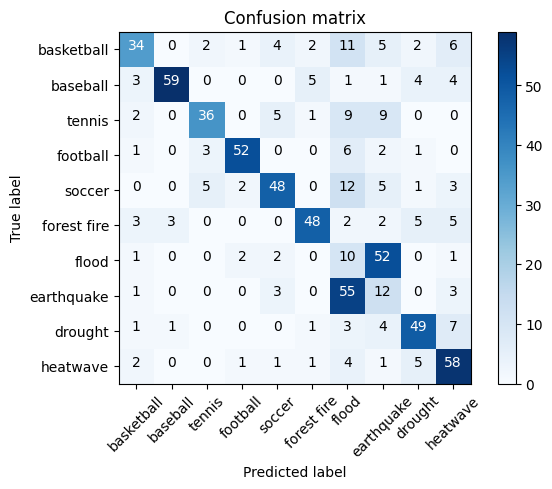

Multiclass NaiveBayes TFIDF Accuracy Score: 0.5833333333333334
Multiclass NaiveBayes TFIDF Recall Score: 0.5833333333333334
Multiclass NaiveBayes TFIDF Precision Score: 0.5833333333333334
Multiclass NaiveBayes TFIDF f1 Score: 0.5833333333333334
Multiclass NaiveBayes LSI Confusion matrix:

Confusion matrix, without normalization
[[57  0  2  0  0  0  2  1  1  4]
 [ 6 66  0  0  0  2  0  0  0  3]
 [ 5  0 53  0  1  0  0  2  0  1]
 [ 0  0  0 56  1  0  0  1  1  6]
 [ 0  0  4  0 68  0  1  1  0  2]
 [ 4  1  0  0  0 56  0  0  3  4]
 [ 2  0  9  4  3  0 16 27  0  7]
 [ 3  0  8  0  3  0 25 20  0 15]
 [ 1  1  0  0  0  0  0  0 53 11]
 [ 3  0  0  0  1  0  1  0  1 67]]


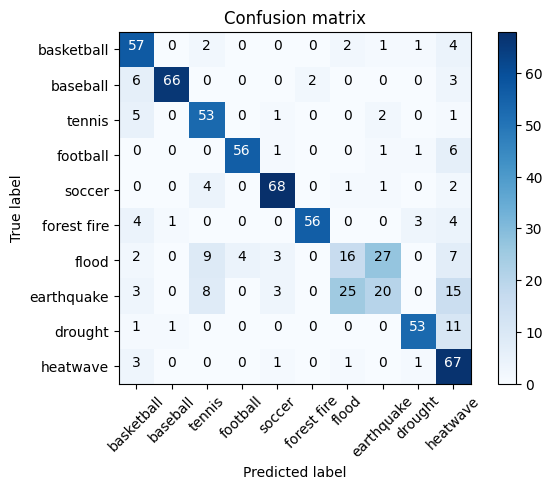

Multiclass NaiveBayes LSI Accuracy Score: 0.735632183908046
Multiclass NaiveBayes LSI Recall Score: 0.735632183908046
Multiclass NaiveBayes LSI Precision Score: 0.735632183908046
Multiclass NaiveBayes LSI f1 Score: 0.735632183908046
Multiclass NaiveBayes NMF Confusion matrix:

Confusion matrix, without normalization
[[44  2  3  0  2  2  2  0  4  8]
 [ 1 72  0  0  0  3  0  0  1  0]
 [ 0  0 54  0  2  1  2  2  0  1]
 [ 1  0  2 57  2  0  0  0  2  1]
 [ 0  0  6  0 68  0  1  1  0  0]
 [ 0  4  0  0  0 59  0  0  4  1]
 [ 2  0 19  0 10  0 18 15  1  3]
 [ 5  0 15  0  8  0 26 12  2  6]
 [ 1  2  0  0  0  1  0  0 55  7]
 [ 4  4  1  0  3  0  0  0  5 56]]


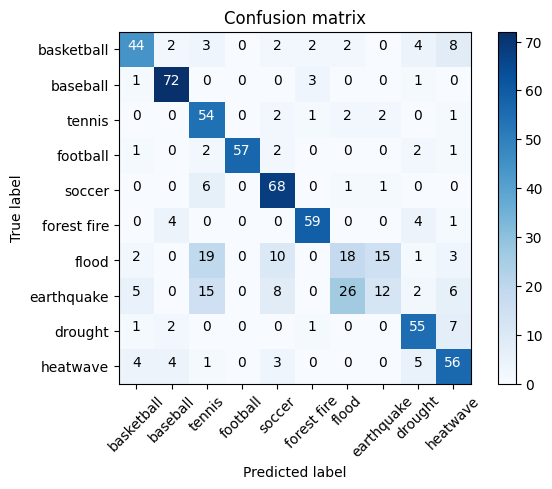

Multiclass NaiveBayes NMF Accuracy Score: 0.7112068965517241
Multiclass NaiveBayes NMF Recall Score: 0.7112068965517241
Multiclass NaiveBayes NMF Precision Score: 0.7112068965517241
Multiclass NaiveBayes NMF f1 Score: 0.711206896551724


In [ ]:
NB_multiclass = GaussianNB()
classes = ['basketball', 'baseball', 'tennis','football', 'soccer','forest fire','flood','earthquake', 'drought', 'heatwave']




labels = ['TFIDF', 'LSI', 'NMF']

for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):
        NB_multiclass.fit(x, y_multi_train)
        NB_multiclass_pred = NB_multiclass.predict(X_multi_test[idx])
        NB_multiclass_confusion = metrics.confusion_matrix(y_true=y_multi_test, y_pred=NB_multiclass_pred)
        NB_multiclass_accuracy = metrics.accuracy_score(y_true=y_multi_test, y_pred=NB_multiclass_pred)
        NB_multiclass_recall = metrics.recall_score(y_true=y_multi_test, y_pred=NB_multiclass_pred, average='micro')
        NB_multiclass_precision = metrics.precision_score(y_true=y_multi_test, y_pred=NB_multiclass_pred, average='micro')
        NB_multiclass_f1 = metrics.f1_score(y_true=y_multi_test, y_pred=NB_multiclass_pred, average='micro')
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Confusion matrix:\n")



        plt.figure(idx)
        plot_confusion_matrix(NB_multiclass_confusion, classes = classes)
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Accuracy Score: " + str(NB_multiclass_accuracy))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Recall Score: " + str(NB_multiclass_recall))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " Precision Score: " + str(NB_multiclass_precision))
        print("Multiclass NaiveBayes " + str(labels[idx]) + " f1 Score: " + str(NB_multiclass_f1))

In [ ]:
#MULTICLASS SVM
# we need two versions
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
svc = LinearSVC(class_weight = 'balanced')
onevone_multiclass_svm = OneVsOneClassifier(svc)
onevall_multiclass_svm = OneVsRestClassifier(svc)

One v One Multiclass SVM TFIDF Confusion matrix:

Confusion matrix, without normalization
[[60  0  0  0  0  1  4  1  0  1]
 [ 0 75  0  0  0  1  0  0  0  1]
 [ 1  0 54  0  2  0  3  2  0  0]
 [ 0  0  0 59  1  0  2  2  1  0]
 [ 0  0  1  0 70  0  1  4  0  0]
 [ 1  1  0  0  0 62  0  0  3  1]
 [ 2  0  1  1  2  0 10 51  0  1]
 [ 3  0  1  0  1  0 60  7  0  2]
 [ 3  0  0  0  0  0  1  0 61  1]
 [ 2  0  0  0  1  0  1  2  0 67]]


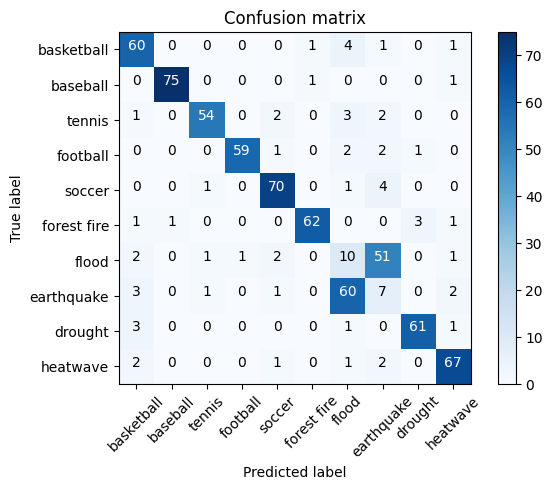

One v One Multiclass SVM TFIDF Accuracy Score: 0.7543103448275862
One v One Multiclass SVM TFIDF Recall Score: 0.7543103448275862
One v One Multiclass SVM TFIDF Precision Score: 0.7543103448275862
One v One Multiclass SVM TFIDF f1 Score: 0.7543103448275862
One v One Multiclass SVM LSI Confusion matrix:

Confusion matrix, without normalization
[[60  0  0  0  0  1  3  1  0  2]
 [ 0 76  0  0  0  1  0  0  0  0]
 [ 1  0 55  0  1  0  2  2  0  1]
 [ 1  0  0 58  1  0  1  0  1  3]
 [ 2  0  1  0 69  0  1  3  0  0]
 [ 1  1  0  0  0 63  0  0  2  1]
 [ 2  0  1  0  3  0 27 33  0  2]
 [ 4  0  1  0  2  0 37 26  0  4]
 [ 1  0  0  0  0  0  0  0 59  6]
 [ 3  1  0  0  1  0  2  1  1 64]]


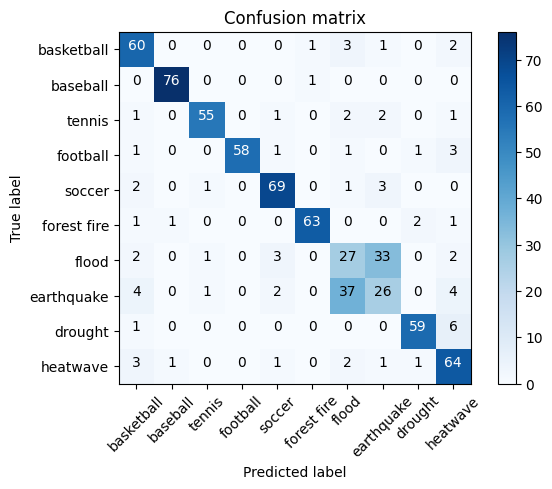

One v One Multiclass SVM LSI Accuracy Score: 0.8002873563218391
One v One Multiclass SVM LSI Recall Score: 0.8002873563218391
One v One Multiclass SVM LSI Precision Score: 0.8002873563218391
One v One Multiclass SVM LSI f1 Score: 0.8002873563218391
One v One Multiclass SVM NMF Confusion matrix:

Confusion matrix, without normalization
[[61  0  0  0  0  1  3  2  0  0]
 [ 7 65  0  0  0  4  0  1  0  0]
 [ 4  0 51  0  1  0  1  5  0  0]
 [ 9  0  0 54  0  0  0  1  1  0]
 [ 7  0  1  0 65  0  2  1  0  0]
 [ 2  1  0  0  0 63  0  0  1  1]
 [ 7  0  1  0  2  0 27 30  0  1]
 [10  0  2  0  1  0 28 31  0  2]
 [ 9  0  0  0  0  0  0  1 55  1]
 [23  0  0  0  0  0  2  0  0 48]]


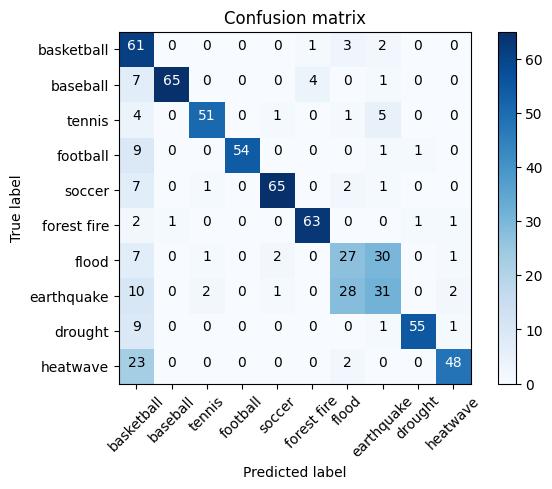

One v One Multiclass SVM NMF Accuracy Score: 0.7471264367816092
One v One Multiclass SVM NMF Recall Score: 0.7471264367816092
One v One Multiclass SVM NMF Precision Score: 0.7471264367816092
One v One Multiclass SVM NMF f1 Score: 0.7471264367816093


In [ ]:
for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):
        onevone_multiclass_svm.fit(x, y_multi_train)
        onevone_multiclass_svm_pred = onevone_multiclass_svm.predict(X_multi_test[idx])
        onevone_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test, y_pred=onevone_multiclass_svm_pred, average='micro')



        print("One v One Multiclass SVM " + labels[idx] + " Confusion matrix:\n")



        plt.figure(idx)
        plot_confusion_matrix(onevone_multiclass_svm_confusion, classes = classes)
        print("One v One Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevone_multiclass_svm_accuracy))
        print("One v One Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevone_multiclass_svm_recall))
        print("One v One Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevone_multiclass_svm_precision))
        print("One v One Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevone_multiclass_svm_f1))

One v All Multiclass SVM TFIDF Confusion matrix:

Confusion matrix, without normalization
[[58  0  2  0  0  1  5  0  0  1]
 [ 0 76  0  0  0  1  0  0  0  0]
 [ 0  0 56  0  1  0  3  2  0  0]
 [ 0  0  0 60  1  0  2  1  1  0]
 [ 0  0  1  0 70  0  2  2  0  1]
 [ 0  2  0  0  0 63  0  0  2  1]
 [ 1  0  1  1  2  0 13 48  0  2]
 [ 1  0  0  0  1  0 63  6  0  3]
 [ 2  1  0  0  0  0  0  2 60  1]
 [ 1  0  0  0  1  0  1  2  0 68]]


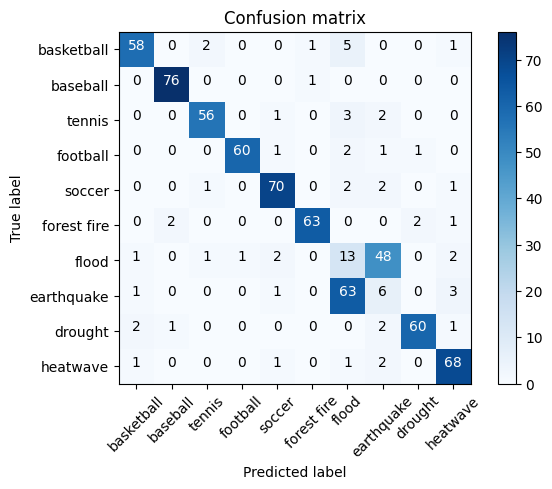

One v All Multiclass SVM TFIDF Accuracy Score: 0.7614942528735632
One v All Multiclass SVM TFIDF Recall Score: 0.7614942528735632
One v All Multiclass SVM TFIDF Precision Score: 0.7614942528735632
One v All Multiclass SVM TFIDF f1 Score: 0.7614942528735632
One v All Multiclass SVM LSI Confusion matrix:

Confusion matrix, without normalization
[[60  0  1  1  0  1  2  2  0  0]
 [ 0 76  0  0  0  1  0  0  0  0]
 [ 2  0 56  0  1  0  1  2  0  0]
 [ 2  0  0 59  1  0  0  0  1  2]
 [ 0  0  1  1 71  0  1  2  0  0]
 [ 0  2  0  0  0 63  0  0  2  1]
 [ 1  0  1  1  4  0 27 33  0  1]
 [ 3  0  2  1  3  0 38 23  1  3]
 [ 0  1  0  0  0  0  0  0 61  4]
 [ 2  0  0  0  1  0  2  0  0 68]]


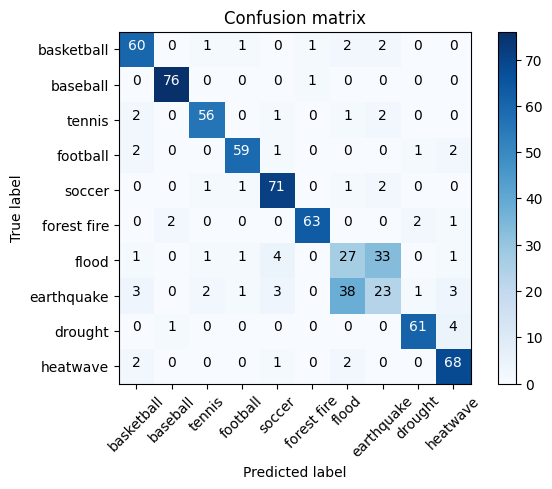

One v All Multiclass SVM LSI Accuracy Score: 0.8103448275862069
One v All Multiclass SVM LSI Recall Score: 0.8103448275862069
One v All Multiclass SVM LSI Precision Score: 0.8103448275862069
One v All Multiclass SVM LSI f1 Score: 0.8103448275862069
One v All Multiclass SVM NMF Confusion matrix:

Confusion matrix, without normalization
[[61  0  1  0  0  1  3  1  0  0]
 [ 0 72  0  0  0  4  0  1  0  0]
 [ 2  0 55  0  1  0  2  2  0  0]
 [ 6  0  0 56  1  0  0  1  1  0]
 [ 2  0  1  0 71  0  1  1  0  0]
 [ 0  2  0  0  0 64  0  0  1  1]
 [ 4  0  1  0  3  1 27 30  0  2]
 [ 8  0  2  0  2  1 32 26  0  3]
 [ 4  0  0  0  0  0  0  1 58  3]
 [ 9  0  0  0  1  0  3  1  0 59]]


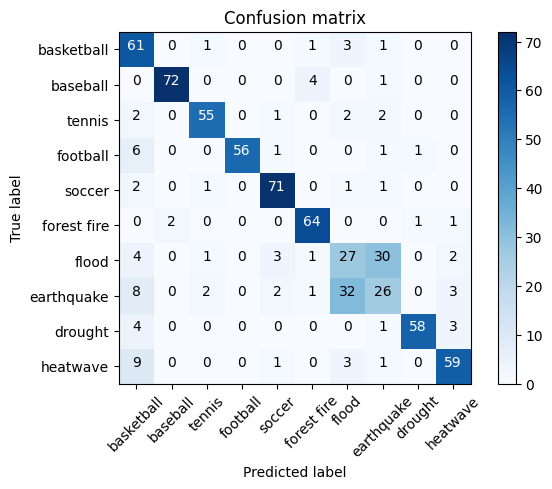

One v All Multiclass SVM NMF Accuracy Score: 0.7887931034482759
One v All Multiclass SVM NMF Recall Score: 0.7887931034482759
One v All Multiclass SVM NMF Precision Score: 0.7887931034482759
One v All Multiclass SVM NMF f1 Score: 0.7887931034482759


In [ ]:
for idx, x in enumerate(X_multi_train):
    if (idx < len(labels)):

        onevall_multiclass_svm.fit(x, y_multi_train)
        onevall_multiclass_svm_pred = onevall_multiclass_svm.predict(X_multi_test[idx])
        onevall_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test, y_pred=onevall_multiclass_svm_pred, average='micro')
        print("One v All Multiclass SVM " + labels[idx] + " Confusion matrix:\n")



        plt.figure(idx)
        plot_confusion_matrix(onevall_multiclass_svm_confusion, classes = classes)


        print("One v All Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevall_multiclass_svm_accuracy))
        print("One v All Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevall_multiclass_svm_recall))
        print("One v All Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevall_multiclass_svm_precision))
        print("One v All Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevall_multiclass_svm_f1))

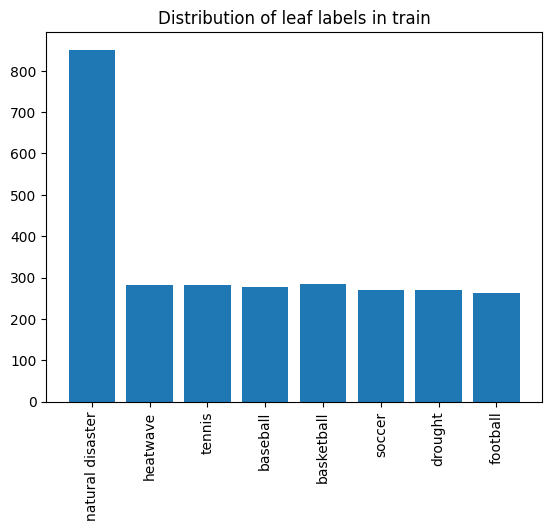

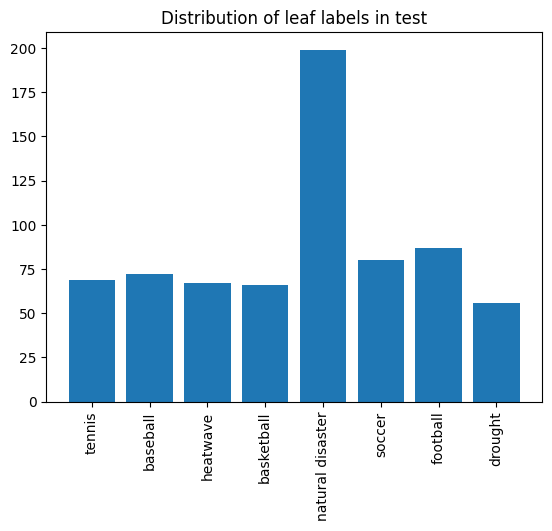

(696, 13584)
(2780, 13584)
One v One Multiclass SVM TFIDF Confusion matrix:

Confusion matrix, without normalization
[[ 63   0   0   1   2   3   0   3]
 [  3  60   0   2   0   0   0   1]
 [  0   0  51   0   4   1   0   0]
 [  0   0   0  85   0   0   1   1]
 [  0   0   1   0  16  48   0   2]
 [  0   0   0   0  64 133   0   2]
 [  3   0   0   0   1   3  72   1]
 [  0   0   0   1   3   1   0  64]]


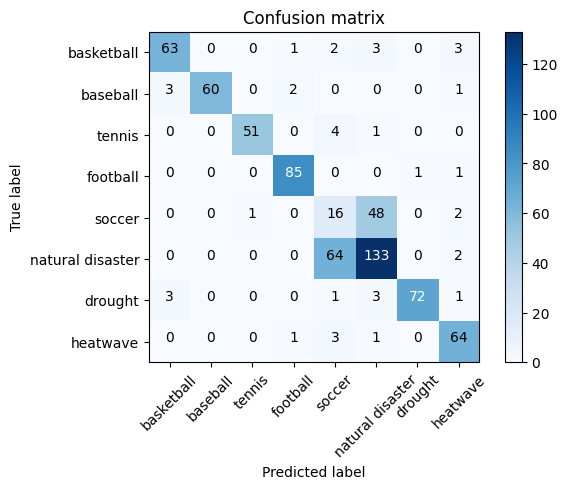

One v One Multiclass SVM TFIDF Accuracy Score: 0.7816091954022989
One v One Multiclass SVM TFIDF Recall Score: 0.7816091954022989
One v One Multiclass SVM TFIDF Precision Score: 0.7816091954022989
One v One Multiclass SVM TFIDF f1 Score: 0.781609195402299
One v One Multiclass SVM LSI Confusion matrix:

Confusion matrix, without normalization
[[ 65   0   2   1   2   1   0   1]
 [  4  58   0   2   0   0   0   2]
 [  1   0  50   0   5   0   0   0]
 [  0   0   0  84   0   0   1   2]
 [  1   0   3   0  58   3   0   2]
 [  5   0   1   0  71 116   0   6]
 [  2   0   0   0   1   0  72   5]
 [  1   0   0   1   2   1   0  64]]


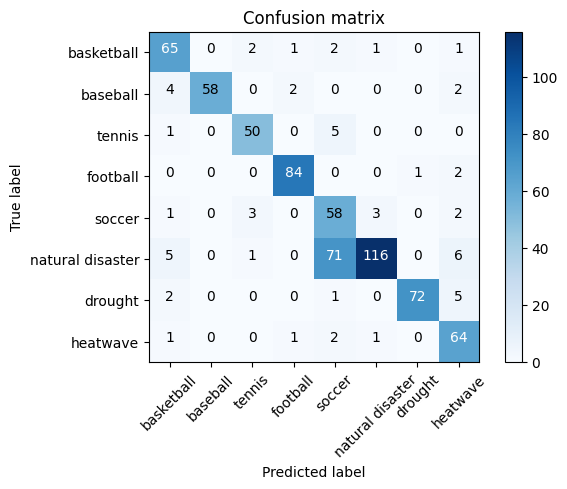

One v One Multiclass SVM LSI Accuracy Score: 0.8146551724137931
One v One Multiclass SVM LSI Recall Score: 0.8146551724137931
One v One Multiclass SVM LSI Precision Score: 0.8146551724137931
One v One Multiclass SVM LSI f1 Score: 0.8146551724137931
One v One Multiclass SVM NMF Confusion matrix:

Confusion matrix, without normalization
[[ 56   0   2   0   1   2   0  11]
 [  3  50   0   3   0   0   0  10]
 [  0   0  44   0   9   2   0   1]
 [  2   0   0  75   0   0   2   8]
 [  0   0   2   0  56   5   0   4]
 [  0   0   1   0  56 124   0  18]
 [  7   0   0   0   0   0  59  14]
 [  2   0   0   1   1   1   0  64]]


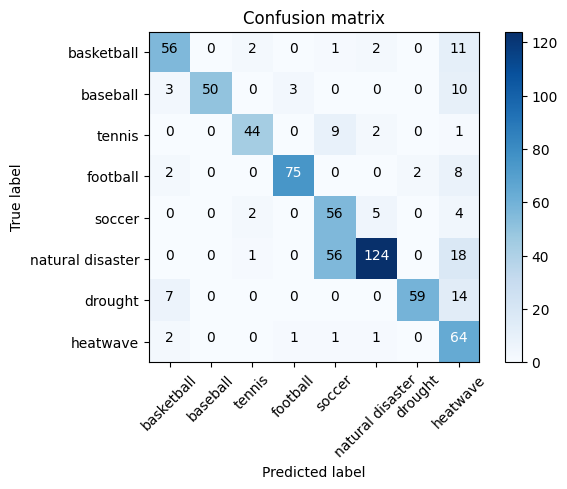

One v One Multiclass SVM NMF Accuracy Score: 0.7586206896551724
One v One Multiclass SVM NMF Recall Score: 0.7586206896551724
One v One Multiclass SVM NMF Precision Score: 0.7586206896551724
One v One Multiclass SVM NMF f1 Score: 0.7586206896551724
One v All Multiclass SVM TFIDF Confusion matrix:

Confusion matrix, without normalization
[[ 60   0   1   1   3   3   0   4]
 [  3  62   0   1   0   0   0   0]
 [  0   0  51   0   4   1   0   0]
 [  0   0   0  85   0   0   1   1]
 [  0   0   0   0  13  52   0   2]
 [  1   0   1   0  61 134   0   2]
 [  3   0   0   1   1   0  74   1]
 [  0   0   0   1   2   1   0  65]]


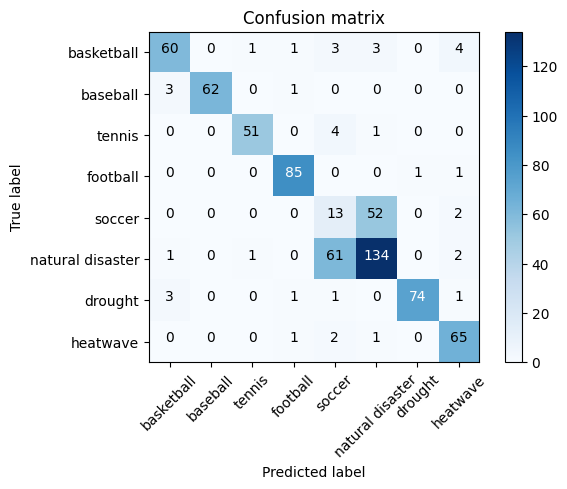

One v All Multiclass SVM TFIDF Accuracy Score: 0.7816091954022989
One v All Multiclass SVM TFIDF Recall Score: 0.7816091954022989
One v All Multiclass SVM TFIDF Precision Score: 0.7816091954022989
One v All Multiclass SVM TFIDF f1 Score: 0.781609195402299
One v All Multiclass SVM LSI Confusion matrix:

Confusion matrix, without normalization
[[ 66   0   0   1   1   3   0   1]
 [  3  60   0   2   0   0   0   1]
 [  1   0  51   0   4   0   0   0]
 [  0   0   0  84   0   0   1   2]
 [  1   0   2   0  56   6   0   2]
 [  5   1   1   0  64 125   0   3]
 [  2   0   0   0   2   0  74   2]
 [  1   0   0   1   1   1   0  65]]


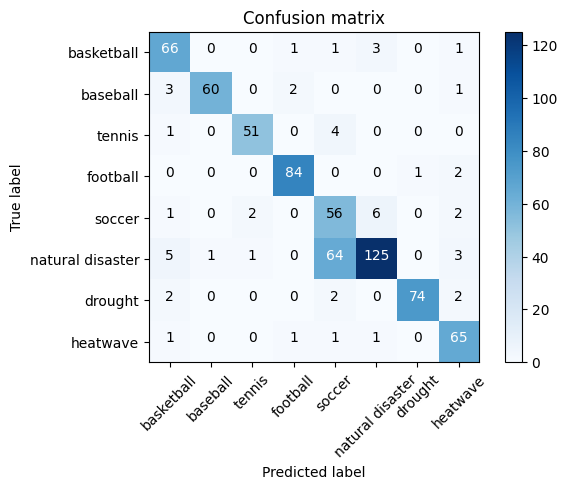

One v All Multiclass SVM LSI Accuracy Score: 0.8347701149425287
One v All Multiclass SVM LSI Recall Score: 0.8347701149425287
One v All Multiclass SVM LSI Precision Score: 0.8347701149425287
One v All Multiclass SVM LSI f1 Score: 0.8347701149425287
One v All Multiclass SVM NMF Confusion matrix:

Confusion matrix, without normalization
[[ 59   0   0   0   1   4   0   8]
 [  2  54   0   3   0   0   1   6]
 [  0   0  44   0  10   2   0   0]
 [  1   0   0  82   0   0   2   2]
 [  0   0   1   0  57   6   0   3]
 [  2   0   1   0  55 128   0  13]
 [  3   0   0   0   0   0  67  10]
 [  1   0   0   1   1   1   0  65]]


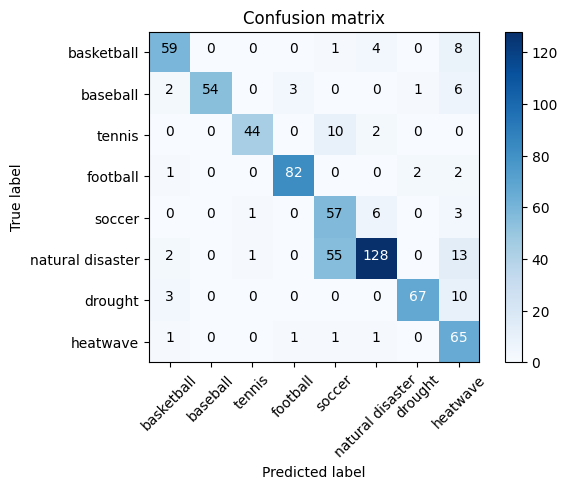

One v All Multiclass SVM NMF Accuracy Score: 0.7988505747126436
One v All Multiclass SVM NMF Recall Score: 0.7988505747126436
One v All Multiclass SVM NMF Precision Score: 0.7988505747126436
One v All Multiclass SVM NMF f1 Score: 0.7988505747126436


In [ ]:
train2, test2 = train_test_split(dataset[["full_text","root_label","leaf_label"]], test_size=0.2)

swap = train2["leaf_label"].copy()
swap2 = test2["leaf_label"].copy()

swap[swap == 'earthquake'] = 'natural disaster'
swap[swap == 'flood'] = 'natural disaster'
swap[swap == 'forest fire'] = 'natural disaster'
train2['leaf_label'] =swap

swap2[swap2 == 'earthquake'] = 'natural disaster'
swap2[swap2 == 'flood'] = 'natural disaster'
swap2[swap2 == 'forest fire'] = 'natural disaster'
test2['leaf_label'] =swap2

y_train_encoded2 = train2["leaf_label"].copy()
y_test_encoded2 = test2["leaf_label"].copy()

#now need to encode the different labels so that they can be predicted

y_train_encoded2[y_train_encoded2 == 'basketball'] = 0
y_test_encoded2[y_test_encoded2 == 'basketball'] = 0


y_train_encoded2[y_train_encoded2== 'baseball'] = 1
y_test_encoded2[y_test_encoded2 == 'baseball'] = 1

y_train_encoded2[y_train_encoded2 == 'tennis'] = 2
y_test_encoded2[y_test_encoded2 == 'tennis'] = 2

y_train_encoded2[y_train_encoded2 == 'football'] = 3
y_test_encoded2[y_test_encoded2 == 'football'] = 3

y_train_encoded2[y_train_encoded2 == 'soccer'] = 4
y_test_encoded2[y_test_encoded2 == 'soccer'] = 4

y_train_encoded2[y_train_encoded2 == 'natural disaster'] = 5
y_test_encoded2[y_test_encoded2 == 'natural disaster'] = 5

y_train_encoded2[y_train_encoded2 == 'drought'] = 6
y_test_encoded2[y_test_encoded2 == 'drought'] = 6

y_train_encoded2[y_train_encoded2 == 'heatwave'] = 7
y_test_encoded2[y_test_encoded2 == 'heatwave'] = 7

train2['encoded'] = y_train_encoded2.astype(str).astype(int)
test2['encoded'] = y_test_encoded2.astype(str).astype(int)
#clean and lemmmatize
train2['full_text'] = train2['full_text'].apply(lemmatize_with_pos_tag)
test2['full_text'] = test2['full_text'].apply(lemmatize_with_pos_tag)


counter2 = Counter(train2['leaf_label'])
leaf_names2 = counter2.keys()
leaf_counts2 = counter2.values()
# histogram for train
indeces = np.arange(len(leaf_names2))
plt.bar(indeces, leaf_counts2, .8)
plt.xticks(indeces, leaf_names2, rotation = 90)
plt.title("Distribution of leaf labels in train")
plt.show()
counter2 = Counter(test2['leaf_label'])
leaf_names2 = counter2.keys()
leaf_counts2 = counter2.values()
# histogram from train
indeces = np.arange(len(leaf_names2))
plt.bar(indeces, leaf_counts2, .8)
plt.xticks(indeces, leaf_names2, rotation = 90)
plt.title("Distribution of leaf labels in test")
plt.show()

#Feature extraction
vect2 = CountVectorizer(min_df=3, stop_words='english')

#via helper code
#train
X_train_counts2 = vect2.fit_transform(train2['full_text'])
X_train_counts2.shape # 1162 docs, 19610 terms in the training dataset
#test
X_test_counts2 = vect2.transform(test2['full_text'])
print(X_test_counts2.shape)

#TFIDF
tfidf_transformer2 = TfidfTransformer()
X_train_tfidf2 = tfidf_transformer2.fit_transform(X_train_counts2)
X_test_tfidf2 = tfidf_transformer2.transform(X_test_counts2)
print(X_train_tfidf2.shape)

svd2 = TruncatedSVD(n_components = k, n_iter = 7) #Choose random state for consistent results
X_train_LSI2 = svd2.fit_transform(X_train_tfidf2)
X_test_LSI2 = svd2.transform(X_test_tfidf2)


# Non-negative Matrix Factorization (NMF)

nmf2 = NMF(n_components = k, init = 'random', max_iter = 1000)
X_train_NMF2 = nmf2.fit_transform(X_train_tfidf2)
X_test_NMF2 = nmf2.transform(X_test_tfidf2)


X_multi_train2 = [X_train_tfidf2.toarray(), X_train_LSI2, X_train_NMF2]
y_multi_train2 = train2["leaf_label"]
X_multi_test2 = [X_test_tfidf2.toarray(), X_test_LSI2, X_test_NMF2]
y_multi_test2 = test2["leaf_label"]



classes = ['basketball', 'baseball', 'tennis', 'football', 'soccer','natural disaster','drought', 'heatwave']

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
svc = LinearSVC(class_weight = 'balanced')
onevone_multiclass_svm = OneVsOneClassifier(svc)
onevall_multiclass_svm = OneVsRestClassifier(svc)

for idx, x in enumerate(X_multi_train2):
    if (idx < len(labels)):
        # train model
        onevone_multiclass_svm.fit(x, y_multi_train2)
        onevone_multiclass_svm_pred = onevone_multiclass_svm.predict(X_multi_test2[idx])
        onevone_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        print("One v One Multiclass SVM " + labels[idx] + " Confusion matrix:\n")
        plt.figure(idx)
        plot_confusion_matrix(onevone_multiclass_svm_confusion, classes = classes)
        print("One v One Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevone_multiclass_svm_accuracy))
        print("One v One Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevone_multiclass_svm_recall))
        print("One v One Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevone_multiclass_svm_precision))
        print("One v One Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevone_multiclass_svm_f1))

for idx, x in enumerate(X_multi_train2):
    if (idx < len(labels)):
        # train model
        onevall_multiclass_svm.fit(x, y_multi_train2)
        onevall_multiclass_svm_pred = onevall_multiclass_svm.predict(X_multi_test2[idx])
        onevall_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        print("One v All Multiclass SVM " + labels[idx] + " Confusion matrix:\n")
        plt.figure(idx)
        plot_confusion_matrix(onevall_multiclass_svm_confusion, classes = classes)
        print("One v All Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevall_multiclass_svm_accuracy))
        print("One v All Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevall_multiclass_svm_recall))
        print("One v All Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevall_multiclass_svm_precision))
        print("One v All Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevall_multiclass_svm_f1))

Class distribution before downsampling:
natural disaster    1050
basketball           350
baseball             350
tennis               350
football             350
soccer               350
heatwave             350
drought              326
Name: merged_label, dtype: int64

Class distribution after downsampling:
baseball            326
basketball          326
drought             326
football            326
heatwave            326
natural disaster    326
soccer              326
tennis              326
Name: merged_label, dtype: int64


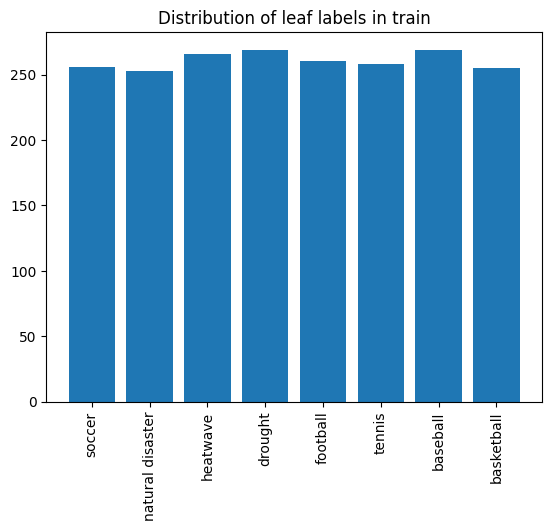

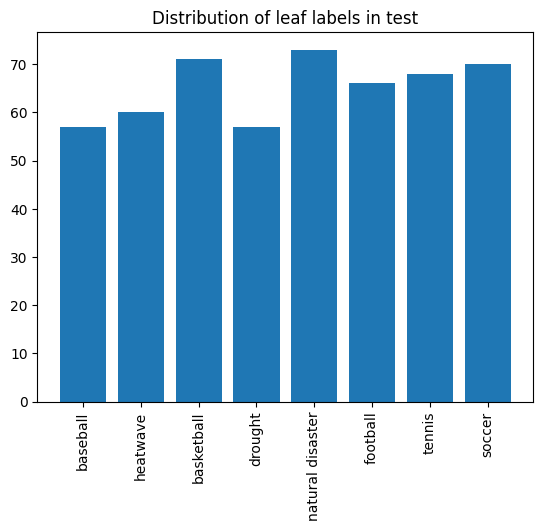

(522, 13082)
(2086, 13082)
One v One Multiclass SVM TFIDF Confusion matrix: 

Confusion matrix, without normalization
[[55  0  1  0  1  0  0  0]
 [ 0 71  0  0  0  0  0  0]
 [ 0  0 51  0  3  2  0  1]
 [ 3  0  0 61  0  0  0  2]
 [ 0  0  1  0 51  8  0  0]
 [ 0  0  1  0 18 53  0  1]
 [ 2  0  0  1  1  1 64  1]
 [ 1  0  0  1  4  1  0 61]]


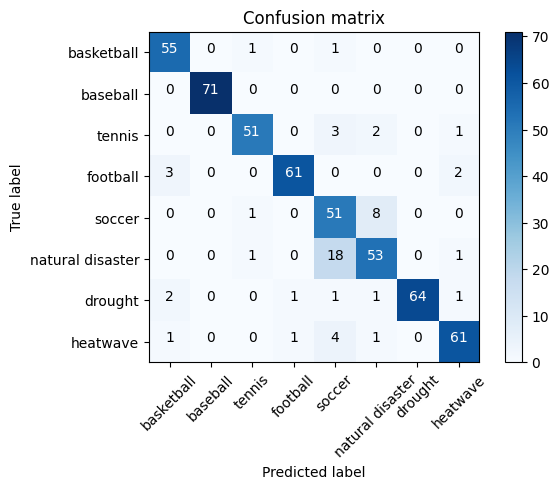

One v One Multiclass SVM TFIDF Accuracy Score: 0.8946360153256705
One v One Multiclass SVM TFIDF Recall Score: 0.8946360153256705
One v One Multiclass SVM TFIDF Precision Score: 0.8946360153256705
One v One Multiclass SVM TFIDF f1 Score: 0.8946360153256705
One v One Multiclass SVM LSI Confusion matrix: 

Confusion matrix, without normalization
[[48  0  0  2  7  0  0  0]
 [ 4 66  0  0  0  0  0  1]
 [ 2  0 48  0  6  1  0  0]
 [ 6  1  0 58  0  0  0  1]
 [ 3  0  0  0 55  2  0  0]
 [ 2  0  1  0 23 46  0  1]
 [ 5  0  0  1  1  0 60  3]
 [ 6  0  0  1  3  0  0 58]]


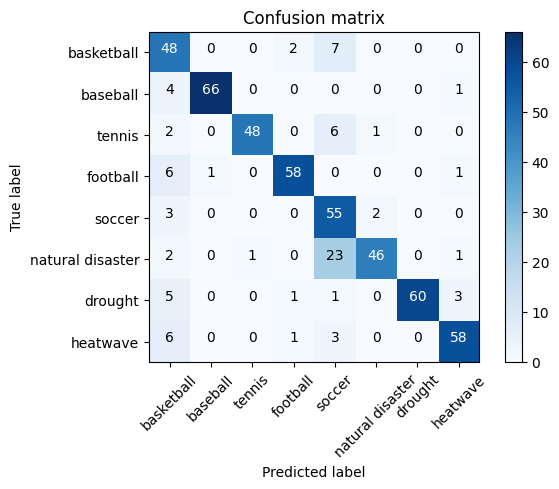

One v One Multiclass SVM LSI Accuracy Score: 0.8409961685823755
One v One Multiclass SVM LSI Recall Score: 0.8409961685823755
One v One Multiclass SVM LSI Precision Score: 0.8409961685823755
One v One Multiclass SVM LSI f1 Score: 0.8409961685823755
One v One Multiclass SVM NMF Confusion matrix: 

Confusion matrix, without normalization
[[43  0  1  3  7  2  1  0]
 [ 2 63  0  2  2  0  2  0]
 [ 1  0 41  0  9  3  3  0]
 [ 6  0  0 57  0  0  2  1]
 [ 3  0  0  0 53  2  2  0]
 [ 1  0  1  0 23 45  3  0]
 [ 2  0  0  2  1  1 60  4]
 [ 7  0  0  1  6  0  3 51]]


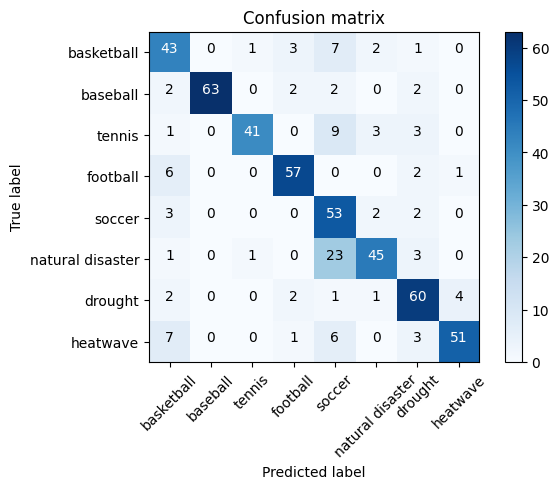

One v One Multiclass SVM NMF Accuracy Score: 0.7911877394636015
One v One Multiclass SVM NMF Recall Score: 0.7911877394636015
One v One Multiclass SVM NMF Precision Score: 0.7911877394636015
One v One Multiclass SVM NMF f1 Score: 0.7911877394636015
One v All Multiclass SVM TFIDF Confusion matrix: 

Confusion matrix, without normalization
[[55  0  1  0  1  0  0  0]
 [ 0 71  0  0  0  0  0  0]
 [ 0  0 51  0  3  2  0  1]
 [ 2  0  0 62  0  0  0  2]
 [ 0  0  1  0 50  9  0  0]
 [ 0  0  1  0 18 53  0  1]
 [ 2  0  0  1  1  1 64  1]
 [ 0  0  1  1  3  0  0 63]]


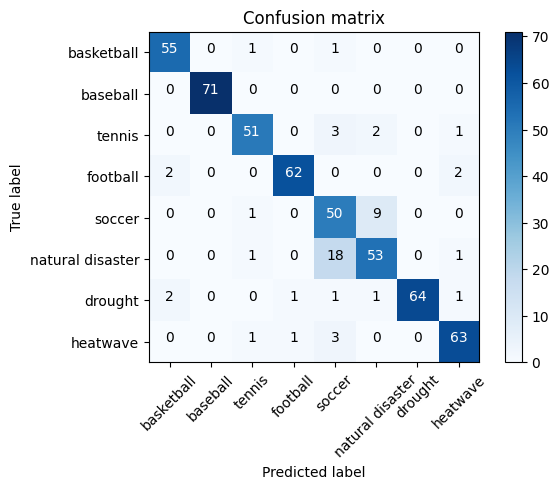

One v All Multiclass SVM TFIDF Accuracy Score: 0.8984674329501916
One v All Multiclass SVM TFIDF Recall Score: 0.8984674329501916
One v All Multiclass SVM TFIDF Precision Score: 0.8984674329501916
One v All Multiclass SVM TFIDF f1 Score: 0.8984674329501916
One v All Multiclass SVM LSI Confusion matrix: 

Confusion matrix, without normalization
[[51  0  1  0  5  0  0  0]
 [ 2 69  0  0  0  0  0  0]
 [ 1  0 48  0  6  1  1  0]
 [ 6  1  0 58  0  0  0  1]
 [ 3  0  1  0 53  3  0  0]
 [ 1  0  1  0 22 47  1  1]
 [ 3  0  0  1  2  0 62  2]
 [ 5  0  0  1  2  1  0 59]]


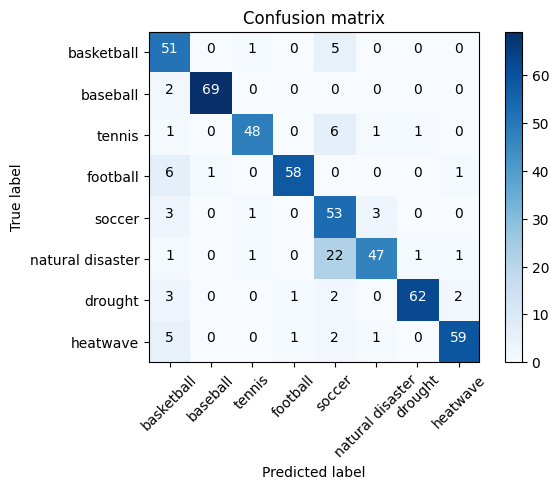

One v All Multiclass SVM LSI Accuracy Score: 0.8563218390804598
One v All Multiclass SVM LSI Recall Score: 0.8563218390804598
One v All Multiclass SVM LSI Precision Score: 0.8563218390804598
One v All Multiclass SVM LSI f1 Score: 0.8563218390804598
One v All Multiclass SVM NMF Confusion matrix: 

Confusion matrix, without normalization
[[44  0  1  3  9  0  0  0]
 [ 2 65  0  2  2  0  0  0]
 [ 1  0 41  0 12  2  1  0]
 [ 7  0  0 57  1  0  0  1]
 [ 4  0  2  0 51  2  0  1]
 [ 1  0  1  0 23 47  1  0]
 [ 2  0  0  2  3  0 60  3]
 [ 6  0  0  1  7  0  0 54]]


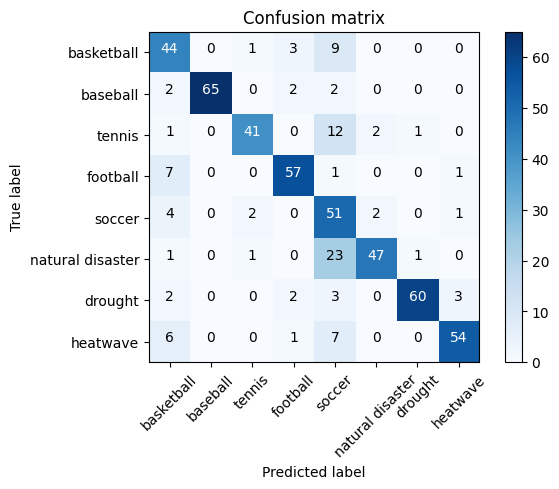

One v All Multiclass SVM NMF Accuracy Score: 0.8026819923371648
One v All Multiclass SVM NMF Recall Score: 0.8026819923371648
One v All Multiclass SVM NMF Precision Score: 0.8026819923371648
One v All Multiclass SVM NMF f1 Score: 0.8026819923371648


In [ ]:
from sklearn.utils import resample
dataset2 = dataset
dataset2['merged_label'] = dataset2['leaf_label'].replace(['flood', 'earthquake', 'forest fire'], 'natural disaster')
print("Class distribution before downsampling:")
print(dataset2['merged_label'].value_counts())
minority_classes = ['soccer', 'football', 'tennis', 'drought', 'basketball', 'baseball']
dataset2 = dataset2.groupby('merged_label', group_keys=False).apply(lambda x: resample(x, replace=True, n_samples=min(x.shape[0], dataset2['merged_label'].value_counts().min()), random_state=42))
dataset2 = dataset2.reset_index(drop=True)

print("\nClass distribution after downsampling:")
print(dataset2['merged_label'].value_counts())

train2, test2 = train_test_split(dataset2[["full_text","root_label","merged_label"]], test_size=0.2)

#Multiclass SVM with earthquake and drought grouped
y_train_encoded2 = train2["merged_label"].copy()
y_test_encoded2 = test2["merged_label"].copy()

#now need to encode the different labels so that they can be predicted

y_train_encoded2[y_train_encoded2 == 'basketball'] = 0
y_test_encoded2[y_test_encoded2 == 'basketball'] = 0


y_train_encoded2[y_train_encoded2== 'baseball'] = 1
y_test_encoded2[y_test_encoded2 == 'baseball'] = 1

y_train_encoded2[y_train_encoded2 == 'tennis'] = 2
y_test_encoded2[y_test_encoded2 == 'tennis'] = 2

y_train_encoded2[y_train_encoded2 == 'football'] = 3
y_test_encoded2[y_test_encoded2 == 'football'] = 3

y_train_encoded2[y_train_encoded2 == 'soccer'] = 4
y_test_encoded2[y_test_encoded2 == 'soccer'] = 4

y_train_encoded2[y_train_encoded2 == 'natural disaster'] = 5
y_test_encoded2[y_test_encoded2 == 'natural disaster'] = 5

y_train_encoded2[y_train_encoded2 == 'drought'] = 6
y_test_encoded2[y_test_encoded2 == 'drought'] = 6

y_train_encoded2[y_train_encoded2 == 'heatwave'] = 7
y_test_encoded2[y_test_encoded2 == 'heatwave'] = 7

train2['encoded'] = y_train_encoded2.astype(str).astype(int)
test2['encoded'] = y_test_encoded2.astype(str).astype(int)
#clean and lemmmatize
train2['full_text'] = train2['full_text'].apply(lemmatize_with_pos_tag)
test2['full_text'] = test2['full_text'].apply(lemmatize_with_pos_tag)


counter2 = Counter(train2['merged_label'])
leaf_names2 = counter2.keys()
leaf_counts2 = counter2.values()
# histogram for train
indeces = np.arange(len(leaf_names2))
plt.bar(indeces, leaf_counts2, .8)
plt.xticks(indeces, leaf_names2, rotation = 90)
plt.title("Distribution of leaf labels in train")
plt.show()
counter2 = Counter(test2['merged_label'])
leaf_names2 = counter2.keys()
leaf_counts2 = counter2.values()
# histogram from train
indeces = np.arange(len(leaf_names2))
plt.bar(indeces, leaf_counts2, .8)
plt.xticks(indeces, leaf_names2, rotation = 90)
plt.title("Distribution of leaf labels in test")
plt.show()

#Feature extraction
vect2 = CountVectorizer(min_df=3, stop_words='english')

#via helper code
#train
X_train_counts2 = vect2.fit_transform(train2['full_text'])
X_train_counts2.shape # 1162 docs, 19610 terms in the training dataset
#test
X_test_counts2 = vect2.transform(test2['full_text'])
print(X_test_counts2.shape)

#TFIDF
tfidf_transformer2 = TfidfTransformer()
X_train_tfidf2 = tfidf_transformer2.fit_transform(X_train_counts2)
X_test_tfidf2 = tfidf_transformer2.transform(X_test_counts2)
print(X_train_tfidf2.shape)

svd2 = TruncatedSVD(n_components = k, n_iter = 7) #Choose random state for consistent results
X_train_LSI2 = svd2.fit_transform(X_train_tfidf2)
X_test_LSI2 = svd2.transform(X_test_tfidf2)


# Non-negative Matrix Factorization (NMF)

nmf2 = NMF(n_components = k, init = 'random', max_iter = 1000)
X_train_NMF2 = nmf2.fit_transform(X_train_tfidf2)
X_test_NMF2 = nmf2.transform(X_test_tfidf2)


X_multi_train2 = [X_train_tfidf2.toarray(), X_train_LSI2, X_train_NMF2]
y_multi_train2 = train2["merged_label"]
X_multi_test2 = [X_test_tfidf2.toarray(), X_test_LSI2, X_test_NMF2]
y_multi_test2 = test2["merged_label"]



classes = ['basketball', 'baseball', 'tennis', 'football', 'soccer','natural disaster','drought', 'heatwave']

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
svc = LinearSVC(class_weight = 'balanced')
onevone_multiclass_svm = OneVsOneClassifier(svc)
onevall_multiclass_svm = OneVsRestClassifier(svc)

for idx, x in enumerate(X_multi_train2):
    if (idx < len(labels)):
        # train model
        onevone_multiclass_svm.fit(x, y_multi_train2)
        onevone_multiclass_svm_pred = onevone_multiclass_svm.predict(X_multi_test2[idx])
        onevone_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred)
        onevone_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        onevone_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test2, y_pred=onevone_multiclass_svm_pred, average='micro')
        print("One v One Multiclass SVM " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(onevone_multiclass_svm_confusion, classes = classes)
        print("One v One Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevone_multiclass_svm_accuracy))
        print("One v One Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevone_multiclass_svm_recall))
        print("One v One Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevone_multiclass_svm_precision))
        print("One v One Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevone_multiclass_svm_f1))

for idx, x in enumerate(X_multi_train2):
    if (idx < len(labels)):
        # train model
        onevall_multiclass_svm.fit(x, y_multi_train2)
        onevall_multiclass_svm_pred = onevall_multiclass_svm.predict(X_multi_test2[idx])
        onevall_multiclass_svm_confusion = metrics.confusion_matrix(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_accuracy = metrics.accuracy_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred)
        onevall_multiclass_svm_recall = metrics.recall_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_precision = metrics.precision_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        onevall_multiclass_svm_f1 = metrics.f1_score(y_true=y_multi_test2, y_pred=onevall_multiclass_svm_pred, average='micro')
        print("One v All Multiclass SVM " + labels[idx] + " Confusion matrix: \n")
        plt.figure(idx)
        plot_confusion_matrix(onevall_multiclass_svm_confusion, classes = classes)
        print("One v All Multiclass SVM " + labels[idx] + " Accuracy Score: " + str(onevall_multiclass_svm_accuracy))
        print("One v All Multiclass SVM " + labels[idx] + " Recall Score: " + str(onevall_multiclass_svm_recall))
        print("One v All Multiclass SVM " + labels[idx] + " Precision Score: " + str(onevall_multiclass_svm_precision))
        print("One v All Multiclass SVM " + labels[idx] + " f1 Score: " + str(onevall_multiclass_svm_f1))

**How did you resolve the class
imbalance issue in the One VS the rest model?**

By using weighting on the classes. As can be seen in the intialization of the support vector classifier.


**Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
major diagonal? What does this mean?**

There is a clear diagonal that can be seen in the resulting confusion matrices. This simply indicates that the true label and predicted label are tending to line up. Darker blues indicate more alignments. Thus a model performing better than random should tend to see the formation of a diagonal.

**Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?**

The classifiers seem to struggle to differentiate earthquakes and droughts and flood and they seem to be somewhat related so we merged them together under natural disasters. The best accuracy for One v One went from .776 to .788, and the best for one vs rest went from .800 to .800 (no change).

**Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?**

Merging leads to class imbalance and does affect the performance, we can see this in the confusion matrices. To fix the imbalance we downsampled the merged label to fall in line with the other classes. As a result One versus One achieved an accuracy of .900 and One versus Rest achieved .902



## Question 10

(a) GLoVE embeddings are trained on the ratio of co-ocurrence probabilities because it is better able to distinguish relevant words from irrelevant words. For example, distinguish _solid_ and _gas_ as a co-ocurrence from _water_ and _fashion_. THe ratio of co-occurrence probabilities is also better at discriminating between two relevant words than the raw probabilities themselves.

(b) GLoVE would not return the same vector for the word **running** because it would factor in contextual words in the sentence. Words such as "park" and "presidency" would thus change the **running** word vector.


In [ ]:
# Implementing part c to calculate the values for the given equations using code provided in project spec
import numpy as np

embeddings_dict = {}
dimension_of_glove = 300
with open("/content/drive/MyDrive/ECE 219/glove/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

In [ ]:
print(np.linalg.norm(embeddings_dict['woman'] - embeddings_dict['man']))
print(np.linalg.norm(embeddings_dict['wife'] - embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['wife'] - embeddings_dict['orange']))

4.7539396
3.1520464
8.667715


(c) _Wife_ is most similar to the word _husband_ with the lowest spatial distance value and _woman_ is most similar to _man_ with a similarly low spacial distance value. Alternatively, _wife_ is not very similar to the word _orange_ due to the higher spatial difference.

(d) Given a word, I'd rather lemmatize it over stemming since performing lemmatization considers the word's context, semantics, syntax, and position tokens. Stemming does not perform any morphological analyses. Lemmatization also accounts for incorrect spelling. While stemming is faster and more efficient, it has a higher error rate leading to us choosing lemmatization into the GLoVE embeddings.

## Question 11

Our feature engineering process that uses GLoVE word embeddings to represent each document:
*   Storing GLoVE embedded words into an embedded vector format using Gensim
*   Clean out redundant information such as lnks, punctuation, and numbers
*   Convert each sentence into vectors the same size as the GLoVE embeddings (size 300)
*   Aggregate normalized final vectors into a single vector



In [ ]:
# Helper class to convert words to vectorized format
class WordToVector:
  def __init__(self, model):
    self.word_vectors = model

  def fit(self, data):
    pass

  def transform(self, data):
    vec = self.word_vectors.get_vector('queen')
    self.D = vec.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    empty_count = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError: pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis = 0)
      else:
        empty_count += 1
      n += 1
    return X

  def fit_transform(self,data):
    self.fit(data)
    return self.transform(data)

In [ ]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

glove_path ="/content/drive/MyDrive/ECE 219/glove/glove.6B.300d.txt"
glove_vec_file = glove_path + ".word2vec"
glove2word2vec(glove_path, glove_vec_file)
model = KeyedVectors.load_word2vec_format(glove_vec_file, binary = False)

vectorizer = WordToVector(model)

In [ ]:
# Re-grab the data for the GLoVE portion
X_train = train['full_text'].apply(clean)
X_test = test['full_text'].apply(clean)

In [ ]:
X_train_glove_fit = vectorizer.fit_transform(X_train)
y_train_glove = y_train_e
X_test_glove_fit = vectorizer.transform(X_test)
y_test_glove = y_test_e

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV

cv_glove = SVC()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 500],
              'kernel' : ['linear']}
glove_model = GridSearchCV(cv_glove, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1).fit(X_train_glove_fit,y_train_glove)
y_labels_glove = glove_model.best_estimator_.predict(X_test_glove_fit)
print(glove_model.best_estimator_)

SVC(C=10, kernel='linear')


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print("Performance of the best GLoVE classifier")
print("Accuracy:", accuracy_score(y_test_glove,y_labels_glove))
print("Recall:", recall_score(y_test_glove,y_labels_glove))
print("Precision:", precision_score(y_test_glove,y_labels_glove))
print("F1-Score:", f1_score(y_test_glove,y_labels_glove))

Performance of the best GLoVE classifier
Accuracy: 0.9511494252873564
Recall: 0.9706744868035191
Precision: 0.9323943661971831
F1-Score: 0.9511494252873564


## Question 12

In [ ]:
#Question 12
#we already have the accuracy for 300; need 50, 100, 200
dimensions  =[50, 100, 200, 300]
accuracies = []
acc_300 = accuracy_score(y_test_glove,y_labels_glove)

In [ ]:
#50
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

embeddings_dict = {}
dimension_of_glove = 50
with open("/content/drive/MyDrive/ECE 219/glove/glove.6B.50d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

glove_path ="/content/drive/MyDrive/ECE 219/glove/glove.6B.50d.txt"
glove_vec_file = glove_path + ".word2vec"
glove2word2vec(glove_path, glove_vec_file)
model = KeyedVectors.load_word2vec_format(glove_vec_file, binary = False)
vectorizer = WordToVector(model)
X_train_glove_fit = vectorizer.fit_transform(X_train)
y_train_glove = y_train_e
X_test_glove_fit = vectorizer.transform(X_test)
y_test_glove = y_test_e



cv_glove = SVC()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 500],
              'kernel' : ['linear']}
glove_model = GridSearchCV(cv_glove, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1).fit(X_train_glove_fit,y_train_glove)
y_labels_glove = glove_model.best_estimator_.predict(X_test_glove_fit)
print(glove_model.best_estimator_)

print("Performance of the best GLoVE classifier")
print("Accuracy:", accuracy_score(y_test_glove,y_labels_glove))
accuracies.append(accuracy_score(y_test_glove,y_labels_glove))
print("Recall:", recall_score(y_test_glove,y_labels_glove))
print("Precision:", precision_score(y_test_glove,y_labels_glove))
print("F1-Score:", f1_score(y_test_glove,y_labels_glove))

SVC(C=10, kernel='linear')
Performance of the best GLoVE classifier
Accuracy: 0.9252873563218391
Recall: 0.9296187683284457
Precision: 0.9188405797101449
F1-Score: 0.924198250728863


In [ ]:
#100
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
embeddings_dict = {}
dimension_of_glove = 100
with open("/content/drive/MyDrive/ECE 219/glove/glove.6B.100d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

glove_path ="/content/drive/MyDrive/ECE 219/glove/glove.6B.100d.txt"
glove_vec_file = glove_path + ".word2vec"
glove2word2vec(glove_path, glove_vec_file)
model = KeyedVectors.load_word2vec_format(glove_vec_file, binary = False)
vectorizer = WordToVector(model)
X_train_glove_fit = vectorizer.fit_transform(X_train)
y_train_glove = y_train_e
X_test_glove_fit = vectorizer.transform(X_test)
y_test_glove = y_test_e

cv_glove = SVC()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 500],
              'kernel' : ['linear']}
glove_model = GridSearchCV(cv_glove, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1).fit(X_train_glove_fit,y_train_glove)
y_labels_glove = glove_model.best_estimator_.predict(X_test_glove_fit)
print(glove_model.best_estimator_)

print("Performance of the best GLoVE classifier")
print("Accuracy:", accuracy_score(y_test_glove,y_labels_glove))
accuracies.append(accuracy_score(y_test_glove,y_labels_glove))
print("Recall:", recall_score(y_test_glove,y_labels_glove))
print("Precision:", precision_score(y_test_glove,y_labels_glove))
print("F1-Score:", f1_score(y_test_glove,y_labels_glove))

SVC(C=10, kernel='linear')
Performance of the best GLoVE classifier
Accuracy: 0.9497126436781609
Recall: 0.967741935483871
Precision: 0.9322033898305084
F1-Score: 0.9496402877697842


In [ ]:
#200
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
embeddings_dict = {}
dimension_of_glove = 200
with open("/content/drive/MyDrive/ECE 219/glove/glove.6B.200d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

glove_path ="/content/drive/MyDrive/ECE 219/glove/glove.6B.200d.txt"
glove_vec_file = glove_path + ".word2vec"
glove2word2vec(glove_path, glove_vec_file)
model = KeyedVectors.load_word2vec_format(glove_vec_file, binary = False)
vectorizer = WordToVector(model)
X_train_glove_fit = vectorizer.fit_transform(X_train)
y_train_glove = y_train_e
X_test_glove_fit = vectorizer.transform(X_test)
y_test_glove = y_test_e


cv_glove = SVC()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 500],
              'kernel' : ['linear']}
glove_model = GridSearchCV(cv_glove, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1).fit(X_train_glove_fit,y_train_glove)
y_labels_glove = glove_model.best_estimator_.predict(X_test_glove_fit)
print(glove_model.best_estimator_)

print("Performance of the best GLoVE classifier")
print("Accuracy:", accuracy_score(y_test_glove,y_labels_glove))
accuracies.append(accuracy_score(y_test_glove,y_labels_glove))
print("Recall:", recall_score(y_test_glove,y_labels_glove))
print("Precision:", precision_score(y_test_glove,y_labels_glove))
print("F1-Score:", f1_score(y_test_glove,y_labels_glove))

SVC(C=10, kernel='linear')
Performance of the best GLoVE classifier
Accuracy: 0.9468390804597702
Recall: 0.9736070381231672
Precision: 0.9222222222222223
F1-Score: 0.9472182596291013


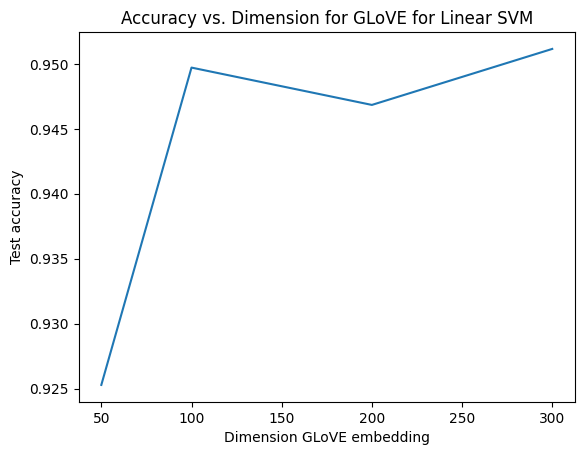

In [ ]:
accuracies.append(acc_300)
plt.plot(dimensions,accuracies)
plt.title('Accuracy vs. Dimension for GLoVE for Linear SVM')
plt.xlabel('Dimension GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

In [ ]:
print(accuracies)
print(dimensions)

[0.9339080459770115, 0.9367816091954023, 0.9367816091954023, 0.9367816091954023]
[50, 100, 200, 300]


**Describe the observed trend. Is
this trend expected? Why or why not?**

We see an upward logarithmic trend, with a dimensionality of 300 showing the best results. This is expected. A higher dimensionality embedding ultimately contains more information with more degrees of freedom that may better be able to capture the complex nature of language. That being said, the differences are not overly dramatic. The logarithmic nature is also expected given that more and more nuance generally contains less important information.

## Question 13

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

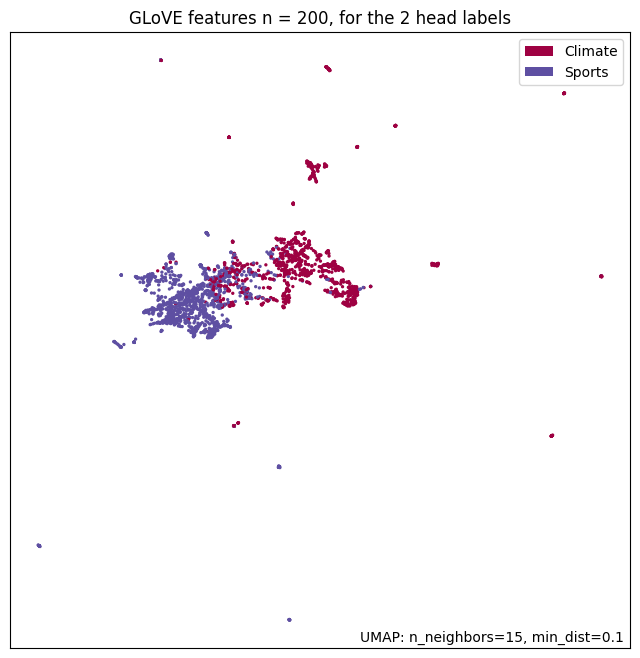

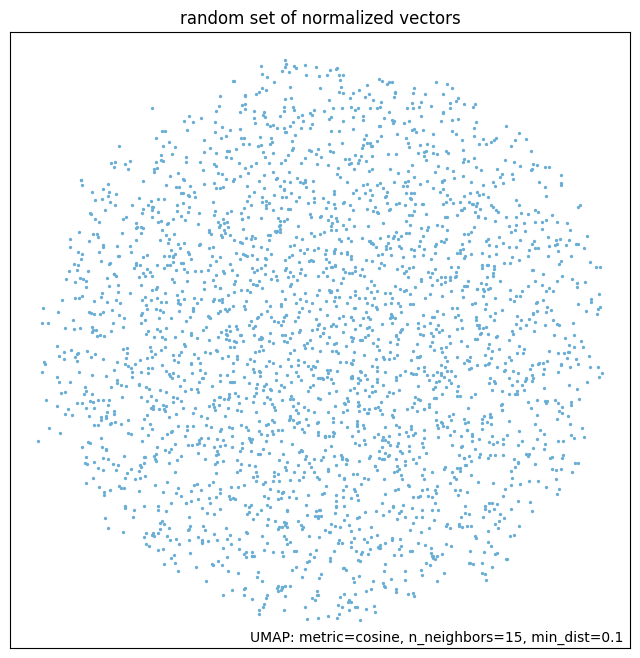

In [ ]:
#13
import umap
import umap.plot
Ytrain_label = []
for label in y_train_glove:
    if(label==0):
        Ytrain_label.append('Sports')
    else:
        Ytrain_label.append('Climate')
#map the points to 2D
data_mapper = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_glove_fit)
umap.plot.points(data_mapper, labels=np.array(Ytrain_label))
plt.title('GLoVE features n = 200, for the 2 head labels')

#generate and normalize
rand = np.random.normal(0, 1, [2780,200])
rand /= np.linalg.norm(rand)
random_mapper = umap.UMAP(n_components=2, metric='cosine').fit(rand)

#Plot random points
umap.plot.points(random_mapper)
plt.title('random set of normalized vectors')
plt.show()

**Compare and contrast the two visualizations. Are there clusters formed in either
or both of the plots?**

For our glove embedding plot we see clear clustering of the individual classes. This is not the case for the random normalized vectors, where we see no clustering. One could note also the overarching clustering of all the data points in the glove embedding when compared to the random set.